In [186]:

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from arch import arch_model
from scipy.stats import norm
import scipy.stats
import pylab
import plotly.graph_objects as go
import seaborn as sns
import pymannkendall as mk
import plotly.express as px
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

## Load and Transform Data

In [270]:
raw_data = pd.read_csv("/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/Other/data/tsla.us.txt")
df = raw_data.copy()
print(df.head())
print(df.shape)
print(df.columns)

         Date   Open   High    Low  Close    Volume  OpenInt
0  2010-06-28  17.00  17.00  17.00  17.00         0        0
1  2010-06-29  19.00  25.00  17.54  23.89  18783276        0
2  2010-06-30  25.79  30.42  23.30  23.83  17194394        0
3  2010-07-01  25.00  25.92  20.27  21.96   8229863        0
4  2010-07-02  23.00  23.10  18.71  19.20   5141807        0
(1858, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


In [271]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)
df = df.asfreq('b', 'ffill')
df.head()

Open   High    Low  Close    Volume  OpenInt
Date                                                     
2010-06-28  17.00  17.00  17.00  17.00         0        0
2010-06-29  19.00  25.00  17.54  23.89  18783276        0
2010-06-30  25.79  30.42  23.30  23.83  17194394        0
2010-07-01  25.00  25.92  20.27  21.96   8229863        0
2010-07-02  23.00  23.10  18.71  19.20   5141807        0

### Visualising

Candlestick charts are very useful in time series analysis, showing falls in prices in red and increases in prices in green.

In [189]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(title='Time Series Analysis (Candlestick Chart)', xaxis_rangeslider_visible=False)
fig.show()

Low closing prices are close (similar) together, while there is a higher variability in the high prices TSLA reaches.

In [191]:
fig = px.box(df, y="Close")
fig.show()

### Analysis on Prices

A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

The following are the components’ definitions:
- The average value in the series is called the level.
- The increasing or falling value in the series is referred to as the trend.
- Seasonality is the series’ recurring short-term cycle.
- The random variance in the series is referred to as noise.

#### Rolling Statistics

We see how mean and standard deviation are not constant over time, implying non-stationarity.

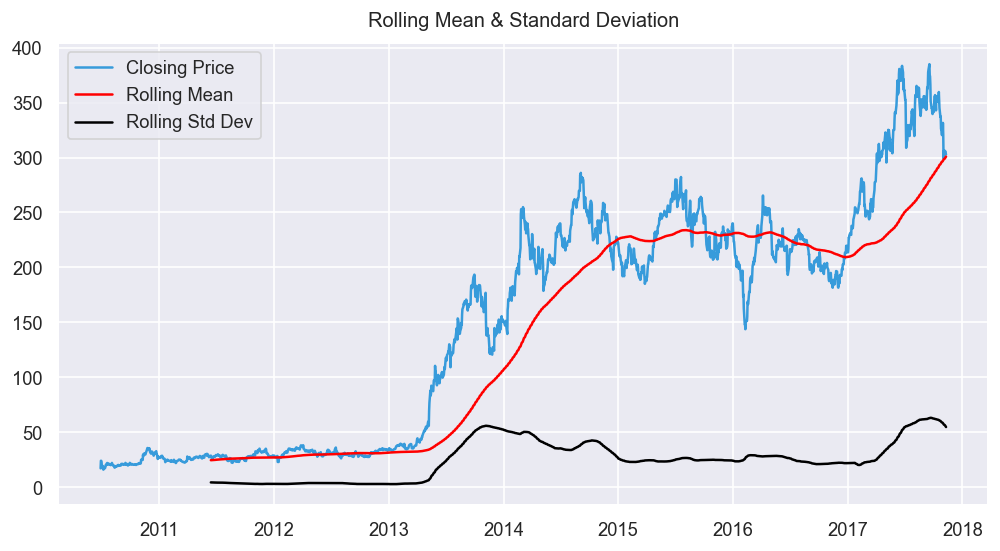

In [192]:
# Quarterly
rolling_avg = df.Close.rolling(window=252).mean()
rolling_std = df.Close.rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(10,5))
plt.plot(df.Close, color='#379BDB', label='Closing Price')
plt.plot(rolling_avg,color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


#### Autocorrelation

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

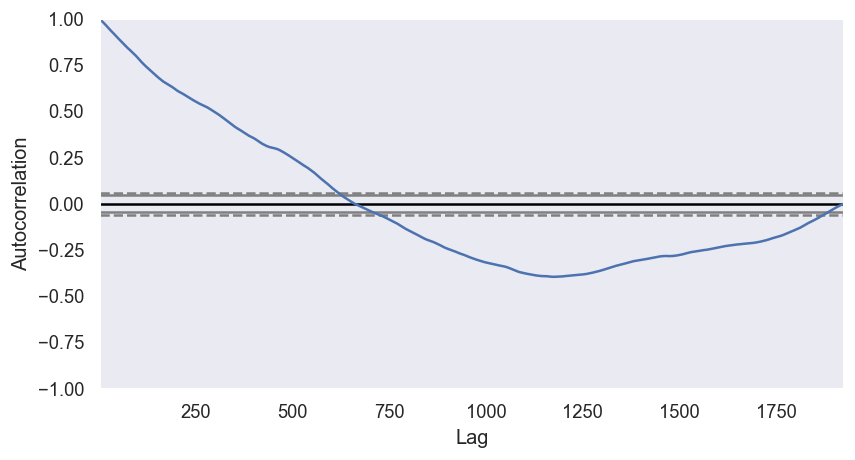

In [193]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(df['Close'].tolist())

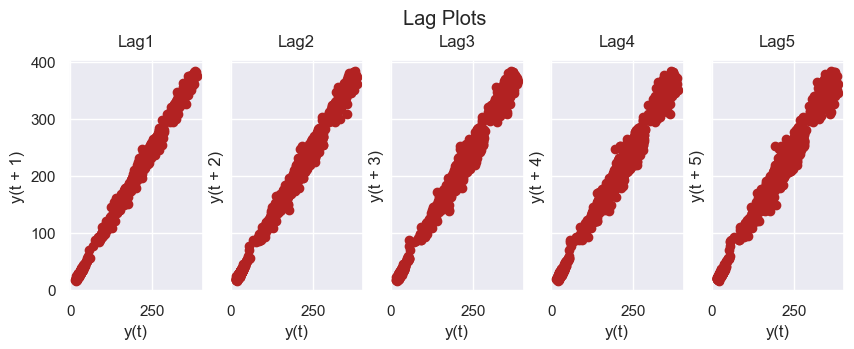

In [194]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left': False, 'axes.titlepad':10})

fig, axes = plt.subplots(1,5, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(df.Close, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag' + str(i+1))
fig.suptitle('Lag Plots', y=1.05)
plt.show()

We see a strong relationship between the current value and the past few lags.

In [195]:
autocorrelation_lag1 = df['Close'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df['Close'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['Close'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['Close'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

autocorrelation_lag12 = df['Close'].autocorr(lag=12)
print("Twelve Month Lag: ", autocorrelation_lag12)

One Month Lag:  0.9990308955847969
Three Month Lag:  0.9969479697390803
Six Month Lag:  0.9940668774379239
Nine Month Lag:  0.9911489791429818
Twelve Month Lag:  0.9880447554351642


#### Seasonality

- Additive time series:\
Value = Base Level + Trend + Seasonality + Error

- Multiplicative Time Series:\
Value = Base Level x Trend x Seasonality x Error

We see an upwards trend, and that the data is not really seasonal.

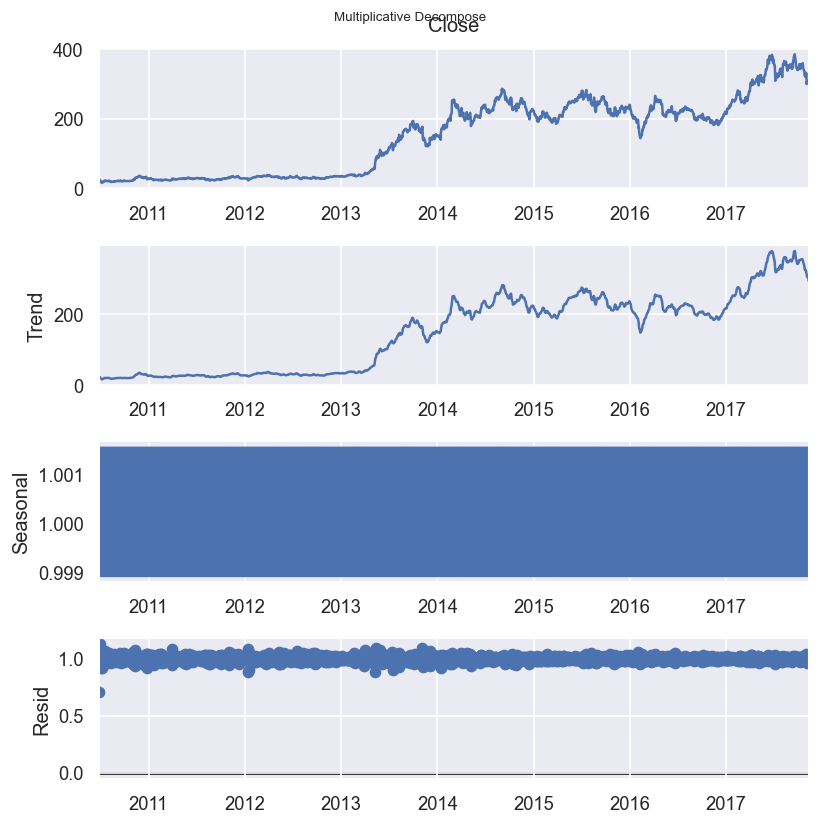

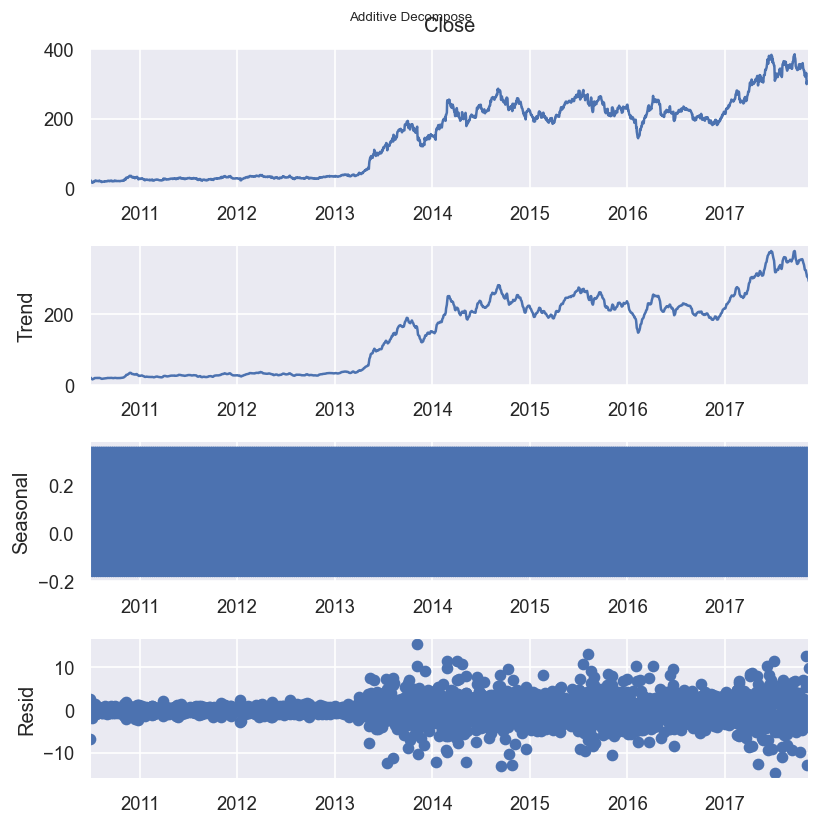

In [196]:
# Multiplicative Decomposition
result_mult = seasonal_decompose(df.Close, model='multiplicative', extrapolate_trend='freq')

# Aditive Decomposition
result_add = seasonal_decompose(df.Close, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (7,7)})
result_mult.plot().suptitle('Multiplicative Decompose', fontsize=8)
result_add.plot().suptitle('Additive Decompose', fontsize=8)
plt.show()

#### Detrending

The Mann-Kendall Trend Test is used to determine whether or not a trend exists in time series data. It is a non-parametric test, meaning there is no underlying assumption made about the normality of the data.

The hypotheses for the test are as follows:
- H0 (null hypothesis): There is no trend present in the data.
- HA (alternative hypothesis): A trend is present in the data. (This could be a positive or negative trend)

If the p-value of the test is lower than some significance level (common choices are 0.10, 0.05, and 0.01), then there is statistically significant evidence that a trend is present in the time series data.

In [197]:
print (mk.hamed_rao_modification_test(df.Close))

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=3.253525160396009e-08, z=5.5272158819219275, Tau=0.74000594000594, s=1370380.0, var_s=61470753177.93735, slope=0.16939367537291225, intercept=20.9832842912584)


Text(0.5, 1.0, 'TSLA closing prices detrended by subtracting the least squares fit')

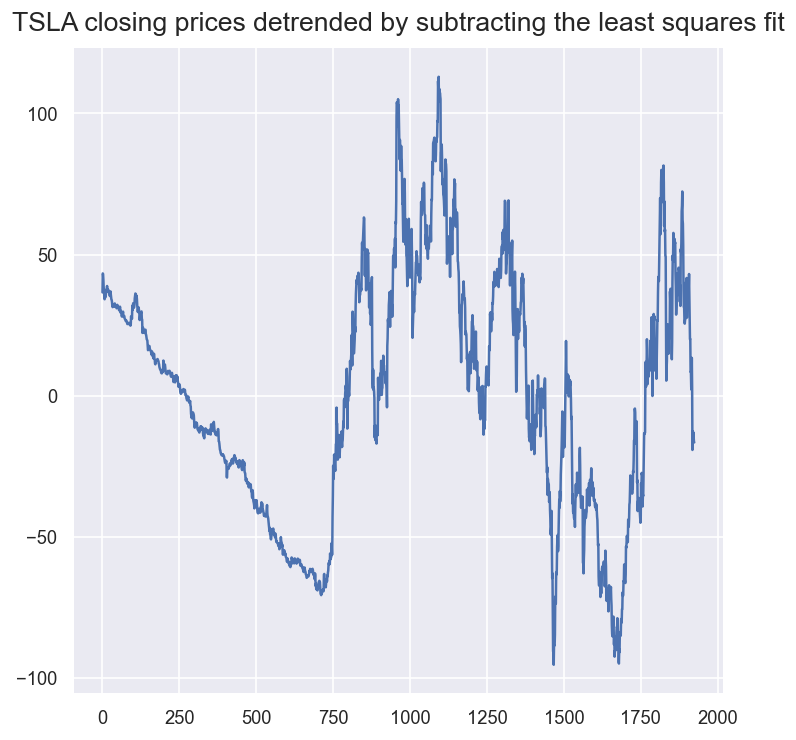

In [198]:
from scipy import signal
detrended = signal.detrend(df['Close'].values)
plt.plot(detrended)
plt.title('TSLA closing prices detrended by subtracting the least squares fit', fontsize=16)

#### ADF Test

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not.
- Null Hypothesis: The series has a unit root (value of a =1)
- Alternate Hypothesis: The series has no unit root.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:
- p-value <= significance level (0.01, 0.05, 0.10, etc.)
- If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Prices data is not stationary, which is expected.

In [199]:
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(df.Close, autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
if dfoutput[1]<0.05:
    print('p-value is %s, meaning that there is enough evidence to say the data is stationary'%dfoutput[1])
else:
    print('p-value is %s, meaning that there is NOT enough evidence to say the data is stationary'%dfoutput[1])

Results of Dickey Fuller Test:
Test Statistic                   -0.803902
p-value                           0.817973
#Lags Used                        3.000000
Number of Observations Used    1921.000000
Critical Value (1%)              -3.433759
Critical Value (5%)              -2.863046
Critical Value (10%)             -2.567572
dtype: float64
p-value is 0.8179732363848067, meaning that there is NOT enough evidence to say the data is stationary


#### ACF & PACF

ACF shows direct and indirect effect of past lags. Estimating MA components.

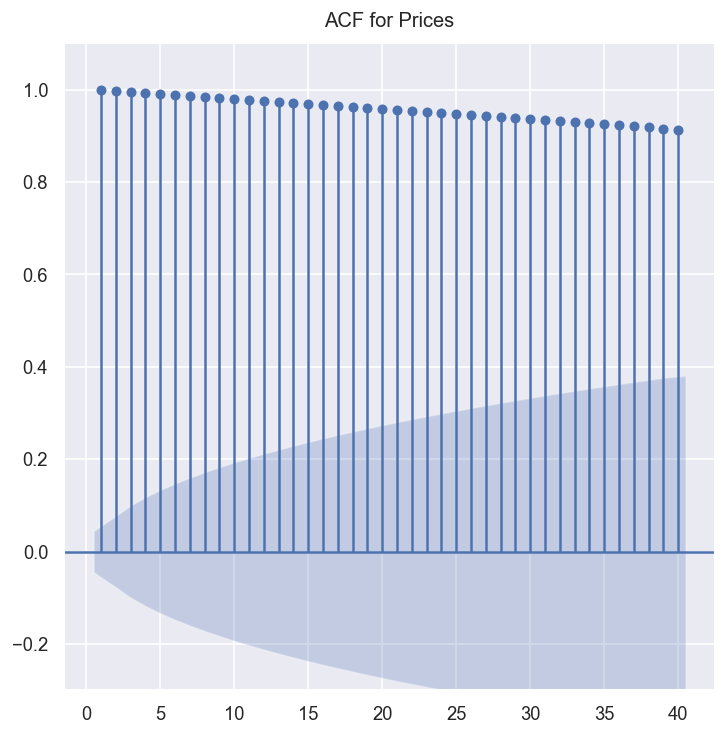

In [200]:
sgt.plot_acf(df.Close, zero=False, lags=40)
plt.title('ACF for Prices')
plt.ylim([-0.3, 1.1])
plt.show()

PACF shows only direct effect of past lags. Estimating AR components.

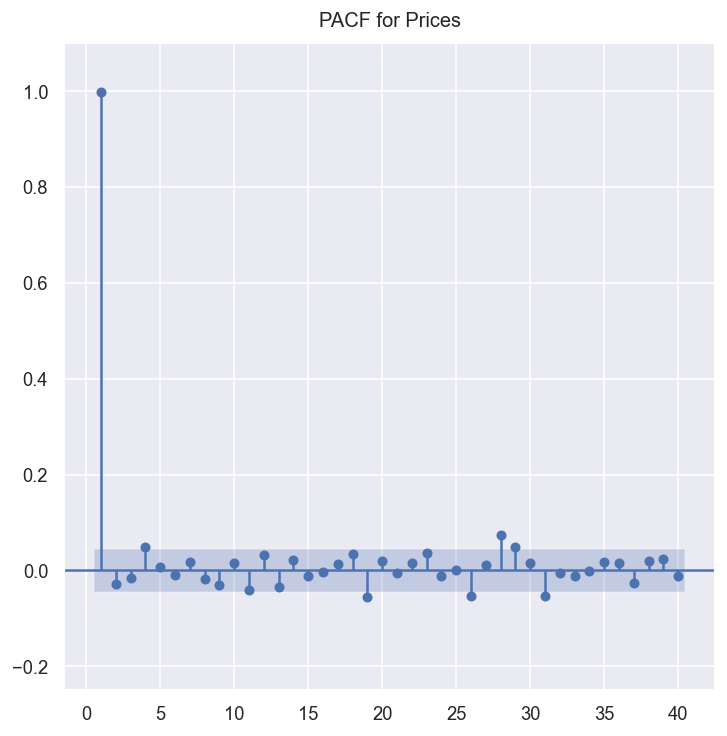

In [201]:
sgt.plot_pacf(df.Close, lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Prices')
plt.ylim([-0.25,1.1])
plt.show()

#### QQ-Plot

If data follows the red line it means it is normally distributed - stock data usually isn't

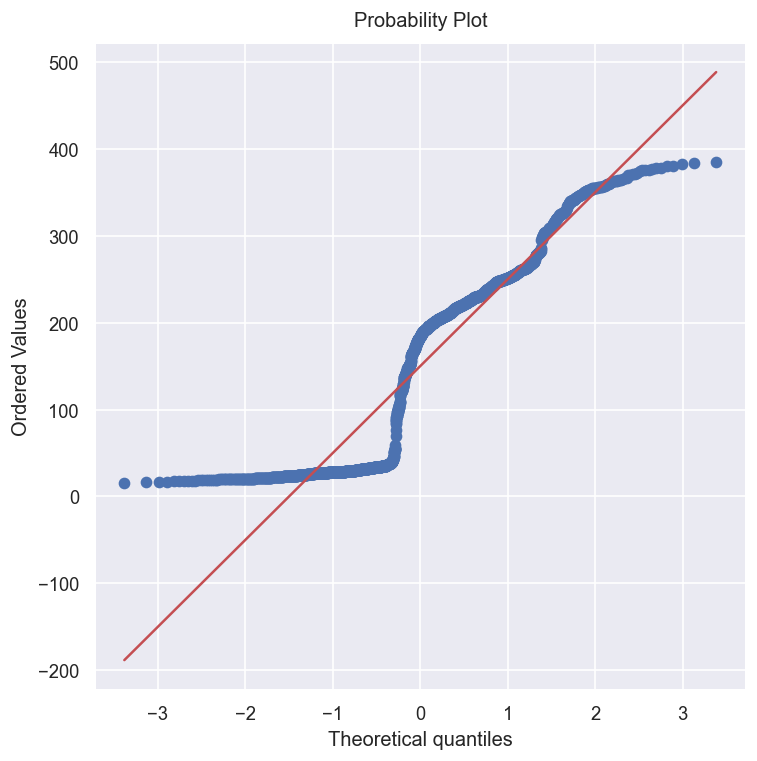

In [202]:
scipy.stats.probplot(df.Close, plot=pylab)
pylab.show()

Data does not follow a normal distribution.

### Analysis on Returns

We calculate the daily returns as the percentage change between one day and the next.

In [274]:
# df['Returns'] = df.Close.apply(np.log)-df.Close.shift(1).apply(np.log)
df['Returns'] = 100*df.Close.pct_change()
df = df.iloc[1:]
df.head()

Open   High    Low  Close    Volume  OpenInt    Returns
Date                                                                
2010-06-29  19.00  25.00  17.54  23.89  18783276        0  40.529412
2010-06-30  25.79  30.42  23.30  23.83  17194394        0  -0.251151
2010-07-01  25.00  25.92  20.27  21.96   8229863        0  -7.847251
2010-07-02  23.00  23.10  18.71  19.20   5141807        0 -12.568306
2010-07-05  23.00  23.10  18.71  19.20   5141807        0   0.000000

#### Visualise

Returns are mostly concentrated within low absolute values, however there are exceptions (outliers).

In [204]:
fig = px.box(df, y="Returns")
fig.show()

Mean Return: 0.2027668042164697, Volatility: 10.845406717440312


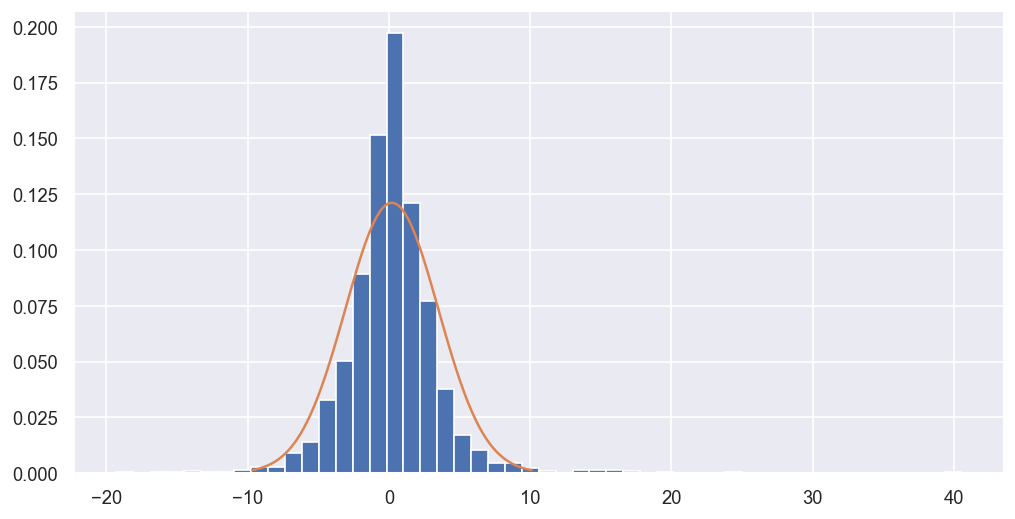

In [207]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(df.Returns, bins=50, density=True)

mean_return = np.mean(df.Returns)
volatility = np.var(df.Returns)
print("Mean Return: " + str(mean_return) + ", Volatility: " + str(volatility))
std_dev = np.sqrt(volatility)


x_axis = np.linspace(mean_return - 3*std_dev,mean_return+3*std_dev, 100)
plt.plot(x_axis, norm.pdf(x_axis,mean_return,std_dev))
plt.show()

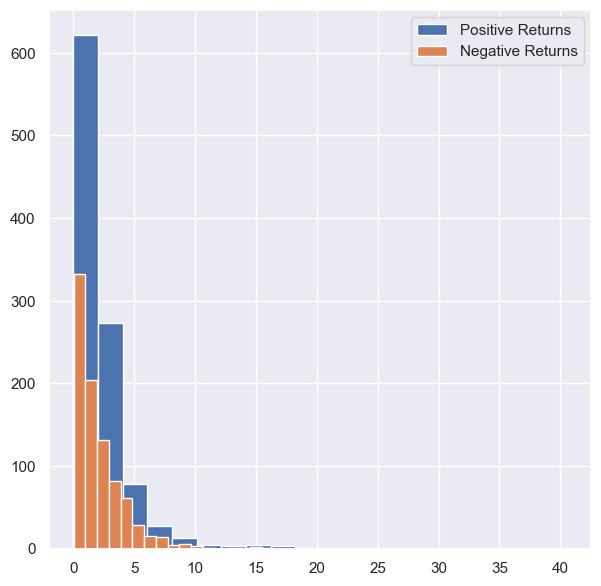

In [28]:
positive_returns = df.loc[df['Returns']>=0].Returns
negative_returns  = df.loc[df['Returns']<0].Returns
plt.hist(sorted(positive_returns.values), bins=20, label='Positive Returns')
plt.hist(sorted(abs(negative_returns.values)), bins=20, label='Negative Returns')
plt.legend(loc='best')

#### Skewness and kurtosis

We can reject that the the returns have skew and kurtosis of the normal distribution

- Right skew (also called positive skew). A right-skewed distribution is longer on the right side of its peak than on its left.
- Left skew (also called negative skew). A left-skewed distribution is longer on the left side of its peak than on its right.
- Zero skew.

- Mesorkurtic (kurtosis = 3): similar to that of the normal distribution
- Leptokurtic (kurtosis > 3): distribution has fat tails (outliers) and is skinny around the mean.\
A stock with a leptokurtic distribution generally depicts a high level of risk but the possibility of higher returns because the stock has typically demonstrated large price movements.
- Platykurtic (kurtosis < 3): distribution has short tails (fewer outliers).\
Platykurtic distributions have demonstrated more stability than other curves because extreme price movements rarely occurred in the past. This translates into a less-than-moderate level of risk.


In [29]:
# Leptokurtic - kurttosis > 3 (higher than normal distribution)
print(scipy.stats.kurtosistest(df.Returns))

# Positively skewed - outliers towards the right (positive returns)
print(scipy.stats.skewtest(df.Returns))

KurtosistestResult(statistic=21.3192624860371, pvalue=7.523469226382758e-101)
SkewtestResult(statistic=19.24282062944739, pvalue=1.6214044664937484e-82)


#### VAR

In [30]:
from scipy.stats import norm
conf_level1 = 0.05
var_95 = norm.ppf(conf_level1, mean_return, std_dev)
print(var_95)

-5.214125215325094


#### Rolling Statistics

Returns data has a more constant mean and standard deviation over time.

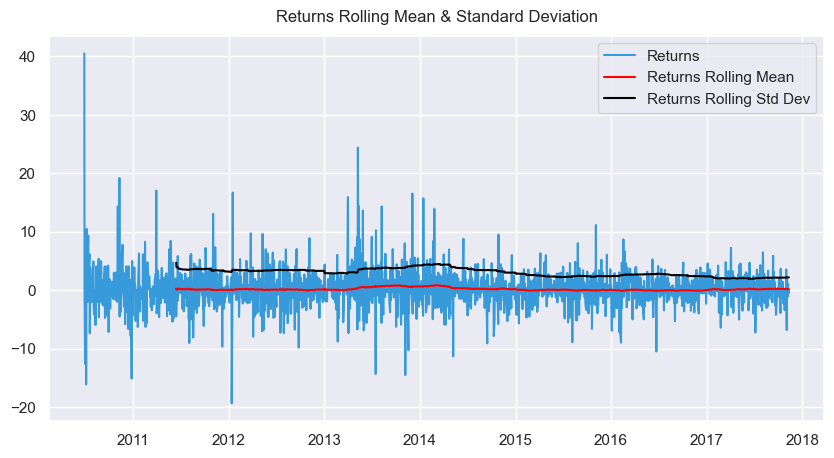

In [826]:
# Yearly values
rolling_avg_ret = df.Returns.rolling(window=252).mean()
rolling_std_ret = df.Returns.rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(10,5))
plt.plot(df.Returns, color='#379BDB', label='Returns')
plt.plot(rolling_avg_ret,color='red', label='Returns Rolling Mean')
plt.plot(rolling_std_ret, color='black', label='Returns Rolling Std Dev')
plt.legend(loc='best')
plt.title('Returns Rolling Mean & Standard Deviation')
plt.show(block=False)


#### Autocorrelation

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

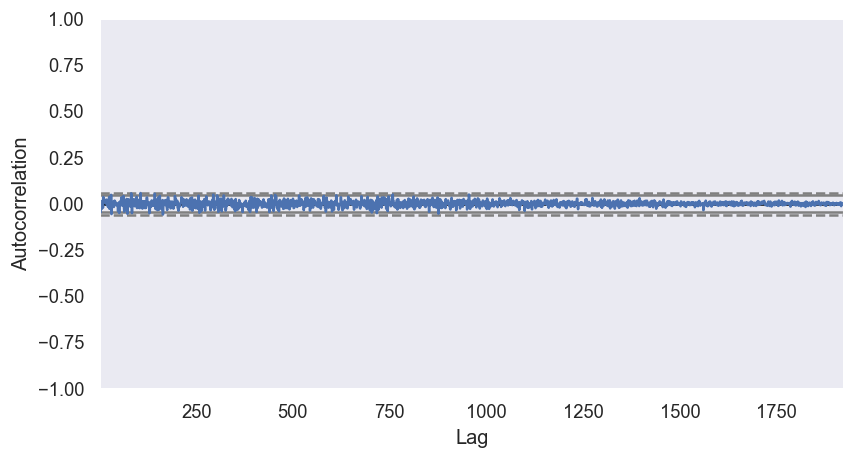

In [36]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(df['Returns'].tolist())

#### ADF Test

We can confirm the returns are stationary.

In [633]:
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(df.Returns, autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
if dfoutput[1]<0.05:
    print('p-value is %s, meaning that there is enough evidence to say the data is stationary'%dfoutput[1])
else:
    print('p-value is %s, meaning that there is NOT enough evidence to say the data is stationary'%dfoutput[1])

Results of Dickey Fuller Test:
Test Statistic                  -32.904414
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1922.000000
Critical Value (1%)              -3.433757
Critical Value (5%)              -2.863045
Critical Value (10%)             -2.567571
dtype: float64
p-value is 0.0, meaning that there is enough evidence to say the data is stationary


#### ACF & PACF

Negative coefficients: today's prices move in the oppositve direction of prices yesterday -> some sort of natural adjustment occuring in the market.

Most of the lagged coefficients for returns do not seem significant.

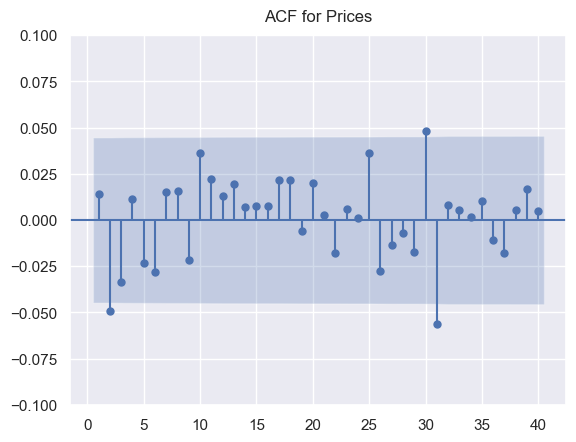

In [634]:
sgt.plot_acf(df.Returns, zero=False, lags=40)
plt.title('ACF for Prices')
plt.ylim([-0.1, 0.1])
plt.show()

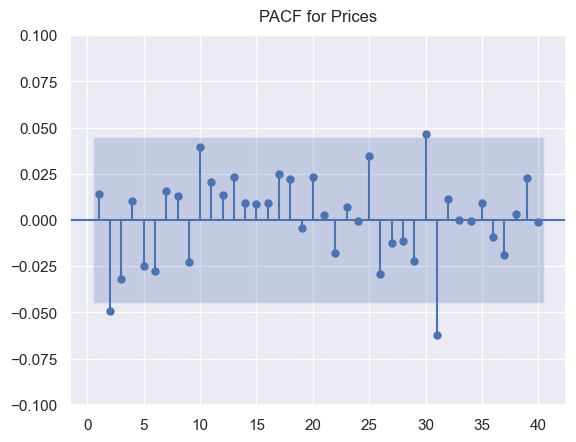

In [635]:
sgt.plot_pacf(df.Returns, lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Prices')
plt.ylim([-0.1,0.1])
plt.show()

#### QQ-Plot

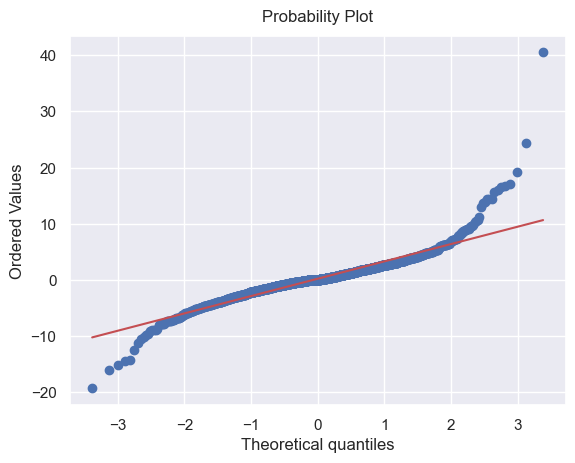

In [636]:
scipy.stats.probplot(df.Returns, plot=pylab)
pylab.show()

## Modelling

To Pick a Model
1. Significant coefficients (not zero, P(z) significant <0.05 - else no predictive power)
2. Parsimomious (as simple as possible) -> LLR
3. Residuals should resemble white noise  -> there isn't a pattern we haven't accounted for
4. Absolute value of coefficients should be less than 1

We can interpret the model as a good fit based on the following conditions.

1. Standardized residual\
There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

2. Histogram plus KDE estimate\
The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

3. Normal Q-Q\
Most of the data points should lie on the straight line

4. Correlogram (ACF plot)\
95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

### Train-test Split

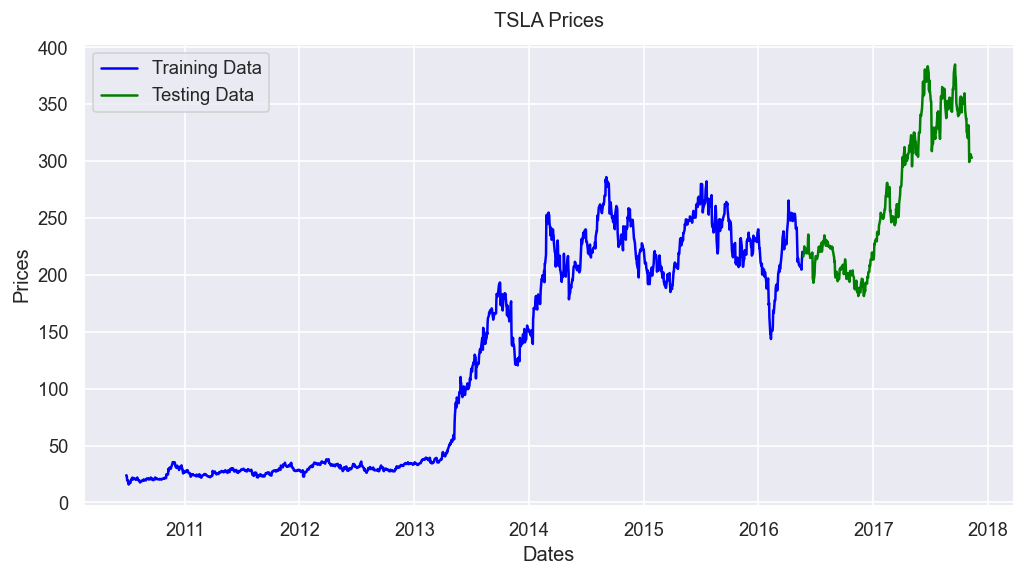

In [275]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]
plt.figure(figsize=(10,5))
plt.title('TSLA Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.Close, 'blue', label='Training Data')
plt.plot(df_test.Close, 'green', label='Testing Data')
plt.legend()

### ARMA on Prices

In [208]:
model_arima_prices = pm.auto_arima(df_train.Close)
model_arima_prices.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1540
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4424.578
Date:                Mon, 08 May 2023   AIC                           8861.156
Time:                        16:14:22   BIC                           8893.189
Sample:                    06-28-2010   HQIC                          8873.074
                         - 05-20-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4018      0.376      1.068      0.286      -0.336       1.139
ar.L1         -1.4282      0.040    -36.028      0.000      -1.506      -1.350
ar.L2         -0.9298      0.036    -25.799      0.000      -1.000      -0.859
ma.L1          1.4159      0.037     38.299      0.000       1.343       1.488
ma.L2          0.9383      0.033     28.180      0.000       0.873       1.004
sigma2        18.3919      0.297     61.904      0.000      17.810      18.974
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):              4294.59
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):              30.85   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

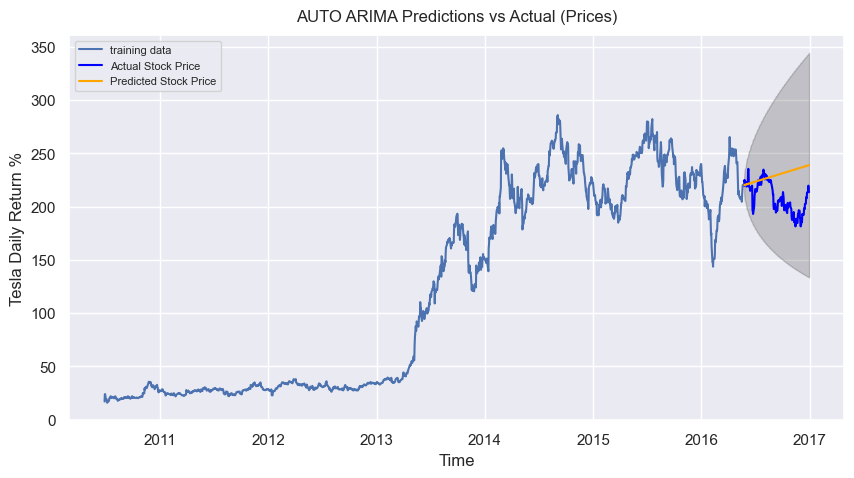

In [210]:
start_date = '2016-05-25'
end_date = '2017-01-01'

# Forecast
df_auto_pred, conf = model_arima_prices.predict(n_periods=len(df_test[start_date:end_date]), return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test[start_date:end_date].index)
lower_series = pd.Series(conf[:, 0], index=df_test[start_date:end_date].index)
upper_series = pd.Series(conf[:, 1], index=df_test[start_date:end_date].index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Close, label='training data')
plt.plot(df_test[start_date:end_date].Close, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Prices)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### ARMA on Returns

AR and MA models not good for non-stationary data.
- AR: fails to adjust quickly to unexpected shocks, accounts only for past values.
- MA: smooths out predictions, taking into account residuals.

ARIMA: better for modelling non-stationary data - e.g. prices.\
Estimates jumps between prices. A single factor of integration is enough to reach stationarity - returns are slightly different.
Repeat for prices and returns and follow these steps for every model. To check integration, integrate .diff(integration_order) and AD-Fuller test to check stationary.

For ARMA and ARIMA examine ACF of residuals. If ACF fails, plot from second element onwards.

- Positive AR coefficients: positive tendency between past and present values -> returns move in trends of consecutive positive or negative values. Periods of persistent increase or decrease when translated to prices.
- Negative AR coefficents: match the expectations of an efficient market. For the efficient market to have a mean around 0, periods of positive returns need to be followed by periods of negative returns.
- Positive MA coefficients: calibrations efforts to minimise the residuals - i.e. close the gap to the actual return value.
- Negative MA coefficients: prevent targets from moving before we have accounted for them.

The further we go back in time, the less relevant values become -> decrease of coefficient's absolute value

In [638]:
model_arima = pm.auto_arima(df_train.Returns)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1539
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4116.108
Date:                Sun, 07 May 2023   AIC                           8244.216
Time:                        11:24:55   BIC                           8276.250
Sample:                    06-29-2010   HQIC                          8256.134
                         - 05-20-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6002      0.255      2.349      0.019       0.099       1.101
ar.L1         -0.6740      0.015    -45.537      0.000      -0.703      -0.645
ar.L2         -0.9737      0.016    -62.667      0.000      -1.004      -0.943
ma.L1          0.6943      0.016     43.690      0.000       0.663       0.725
ma.L2          0.9693      0.017     56.154      0.000       0.935       1.003
sigma2        12.3167      0.170     72.276      0.000      11.983      12.651
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             16594.27
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- There is not an obvious pattern in the residuals, though perhaps a high volatility
- The KDE curve is slightly different from the normal distribuition
- Some points do not follow the line in the QQ plot
- Most coefficients seem not significant

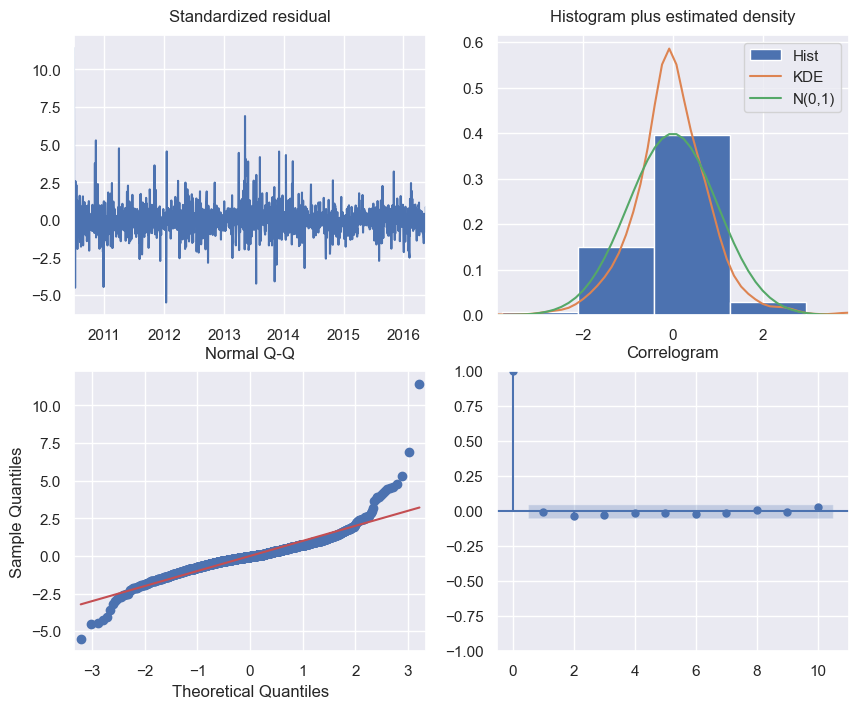

In [639]:
model_arima.plot_diagnostics(figsize=(10,8))
plt.show()

#### Analysing the Residuals

We want error tests to resemble white noise (random)
1. Stationary - DF test
2. Most of the coefficients to be non-significant - ACF plot
3. Look random when we plot them
4. Mean close to 0 to minimise error magnitude and variance close to 0 so that prediction is always close to the true value.

In [640]:
arima_res = model_arima.resid()
print(arima_res.mean())
print(arima_res.std())
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(model_arima.resid(), autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
if dfoutput[1]<0.05:
    print('p-value is %s, meaning that there is enough evidence to say the data is stationary'%dfoutput[1])
else:
    print('p-value is %s, meaning that there is NOT enough evidence to say the data is stationary'%dfoutput[1])

0.0003907503245005619
3.5130622310694766
Results of Dickey Fuller Test:
Test Statistic                  -41.222205
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
dtype: float64
p-value is 0.0, meaning that there is enough evidence to say the data is stationary


Text(0.5, 1.0, 'ACF of Residuals for ARIMA')

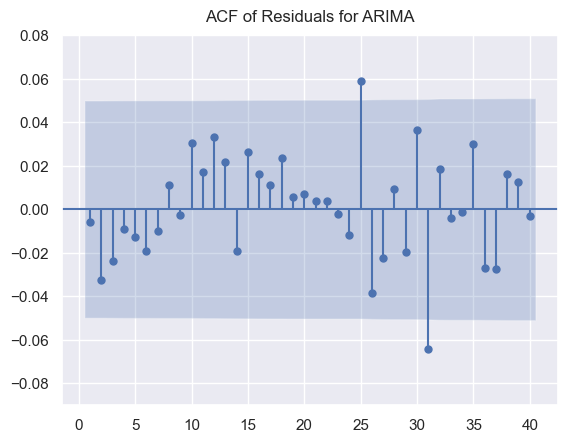

In [641]:
sgt.plot_acf(arima_res, lags=40, zero=False)
plt.ylim(-0.09,0.08)
plt.title('ACF of Residuals for ARIMA')

#### Forecast

In [828]:
df_train.tail()

Open    High     Low   Close   Volume  OpenInt   Returns
Date                                                                  
2016-05-16  208.15  213.15  207.92  208.29  2474446        0  0.327537
2016-05-17  209.05  209.82  204.02  204.66  2303002        0 -1.742762
2016-05-18  209.15  215.31  207.75  211.17  4454848        0  3.180885
2016-05-19  213.62  216.79  207.30  215.21  6582419        0  1.913151
2016-05-20  216.99  220.55  216.35  220.28  8635216        0  2.355838

In [829]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

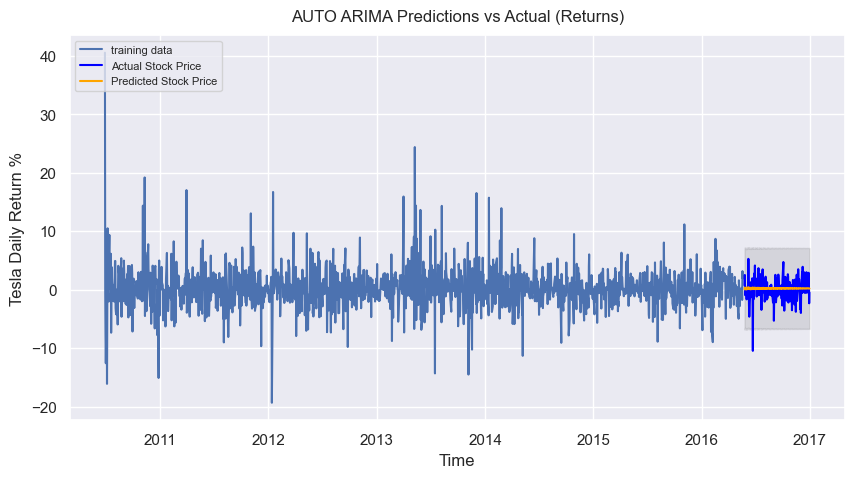

In [864]:
start_date = '2016-05-25'
end_date = '2017-01-01'

# Forecast
df_auto_pred, conf = model_arima.predict(n_periods=len(df_test[start_date:end_date]), return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test[start_date:end_date].index)
lower_series = pd.Series(conf[:, 0], index=df_test[start_date:end_date].index)
upper_series = pd.Series(conf[:, 1], index=df_test[start_date:end_date].index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Returns, label='training data')
plt.plot(df_test[start_date:end_date].Returns, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

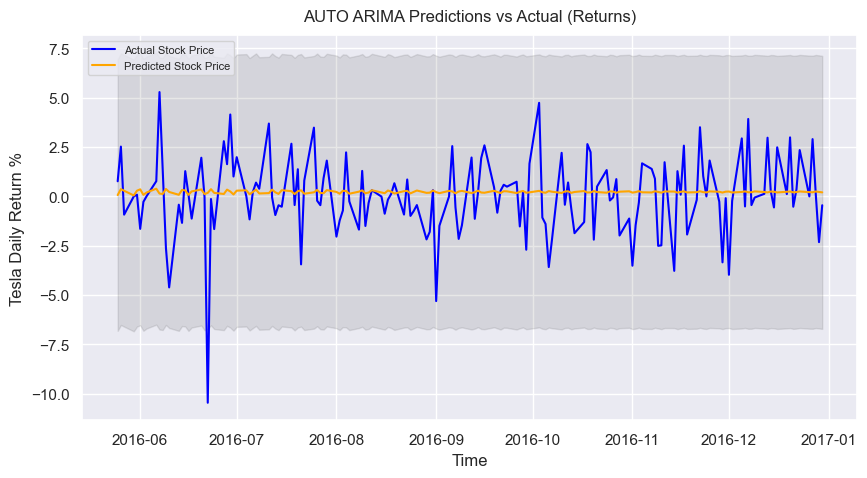

In [865]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_test[start_date:end_date].Returns, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [831]:
error = mean_squared_error(df_test[start_date:end_date].Returns, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test[start_date:end_date].Returns.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 4.071
Symmetric mean absolute percentage error: 165.037


In [702]:
start_date = '2016-05-25'
end_date = '2017-01-01'

history =[x for x in df_train.Returns] 
predictions = []

for t in range(len(df_test[start_date:end_date])):
    model = pm.auto_arima(history)
    output = model_arima.predict(n_periods = 1)
    yhat = output.values[0]
    predictions.append(yhat)
    obs = df_test.Returns[t]
    history.append(obs)

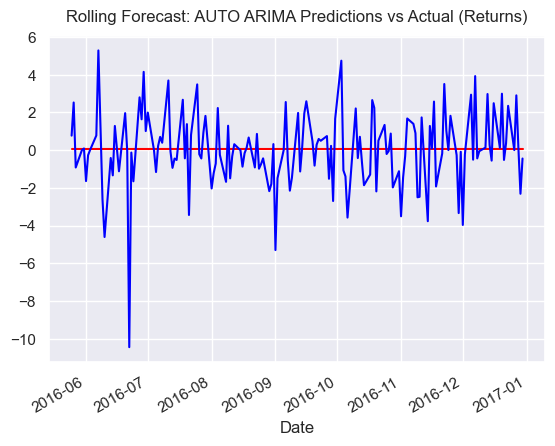

In [703]:
plt.plot(df_test[start_date:end_date].index,predictions, color='red')
df_test.Returns[start_date:end_date].plot(color='blue')
plt.title('Rolling Forecast: AUTO ARIMA Predictions vs Actual (Returns)')
plt.show()

In [ ]:
error = mean_squared_error(df_test[start_date:end_date].Returns, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test[start_date:end_date].Returns.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 4.200
Symmetric mean absolute percentage error: 163.573


### ARIMAX

In [866]:
raw_spx_data = pd.read_csv("/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/Other/data/spy.us.txt")
df_spx = raw_spx_data.copy()
df_spx['Returns'] = 100*df_spx.Close.pct_change()
df_spx = df_spx.iloc[1:]

In [867]:
df_spx.Date = pd.to_datetime(df_spx.Date, dayfirst=True)
df_spx.set_index('Date', inplace=True)
df_spx = df_spx.asfreq('b', 'ffill')

In [868]:
df_spx_train = df_spx.loc[df_train.index]
df_spx_test = df_spx.loc[df_test.index]

In [869]:
x = np.array(df_spx_train.Returns)
x = x.reshape(x.size,1)
x.shape

(1539, 1)

In [870]:
model_arimax = pm.auto_arima(y=df_train.Returns, X=x, m=5)
model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1539
Model:                        SARIMAX   Log Likelihood               -4039.744
Date:                Sun, 07 May 2023   AIC                           8085.489
Time:                        17:50:53   BIC                           8101.506
Sample:                    06-29-2010   HQIC                          8091.448
                         - 05-20-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1614      0.093      1.744      0.081      -0.020       0.343
x1             1.1585      0.082     14.062      0.000       0.997       1.320
sigma2        11.1556      0.147     75.657      0.000      10.867      11.445
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42678.37
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

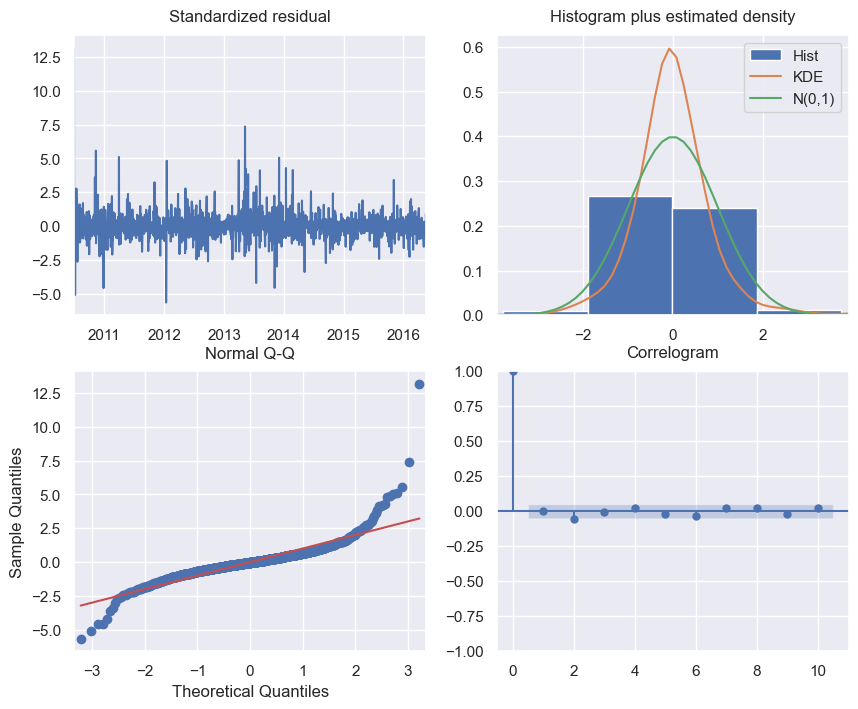

In [679]:
model_arimax.plot_diagnostics(figsize=(10,8))
plt.show()

#### Forecast

In [871]:
x = np.array(df_spx_test.Returns[start_date:end_date])
x = x.reshape(x.size,1)
x.shape

(158, 1)

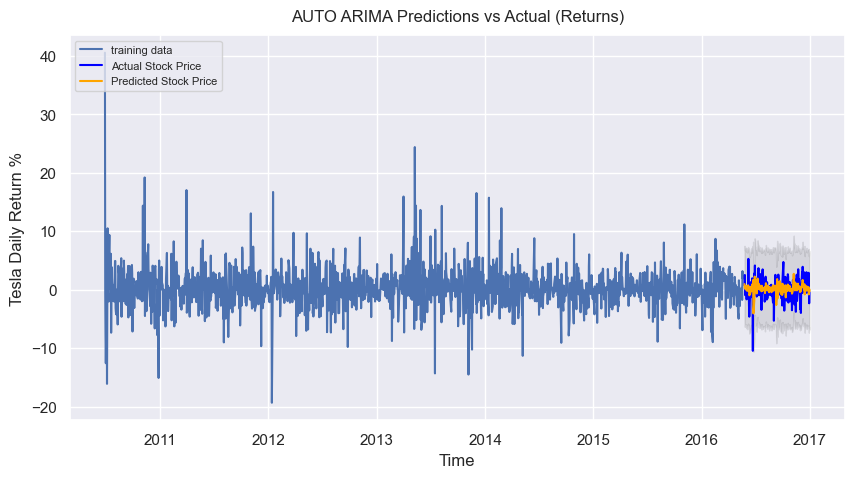

In [872]:
start_date = '2016-05-25'
end_date = '2017-01-01'

# Forecast
df_auto_pred, conf = model_arimax.predict(n_periods=len(df_test[start_date:end_date]), X=x, return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test[start_date:end_date].index)
lower_series = pd.Series(conf[:, 0], index=df_test[start_date:end_date].index)
upper_series = pd.Series(conf[:, 1], index=df_test[start_date:end_date].index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Returns, label='training data')
plt.plot(df_test[start_date:end_date].Returns, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

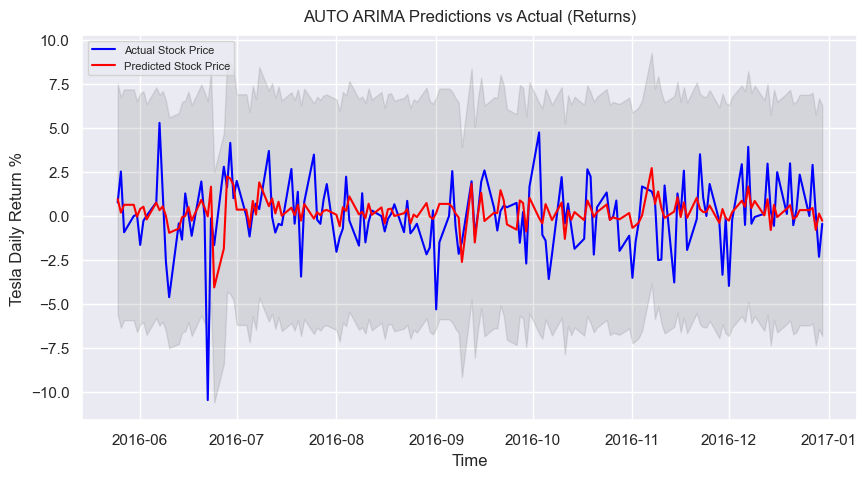

In [873]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_test[start_date:end_date].Returns, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

MSE measures the average of the squares of the errors

In [682]:
error = mean_squared_error(df_test[start_date:end_date].Returns, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test[start_date:end_date].Returns.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 3.737
Symmetric mean absolute percentage error: 157.837


#### Forecast Rolling Window

In [698]:
df_spx_test_ret = df_spx_test['Returns']
type(df_spx_test.iloc[[0]].Returns)

pandas.core.series.Series

In [699]:
start_date = '2016-05-25'
end_date = '2017-01-01'

history =[m for m in df_train.Returns]
exogenous = np.array(df_spx_train.Returns)
exogenous = exogenous.reshape(exogenous.size,1)
predictions = []

for t in range(len(df_test[start_date:end_date])):
    model = pm.auto_arima(y=history, X=exogenous, m=5)
    output = model_arimax.predict(n_periods = 1, X=df_spx_test.iloc[[t]].Returns.to_frame())

    yhat = output.values[0]
    predictions.append(yhat)
    obs = df_test.Returns[t]
    history.append(obs)
    exogenous = np.append(exogenous, df_spx_test.Returns[t])
    exogenous = exogenous.reshape(exogenous.size,1)

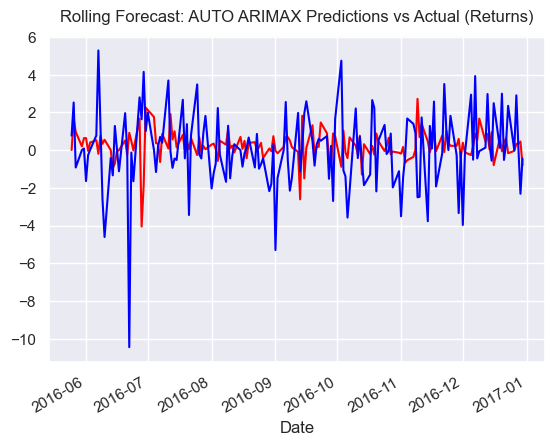

In [700]:
plt.plot(df_test[start_date:end_date].index,predictions, color='red')
df_test.Returns[start_date:end_date].plot(color='blue')
plt.title('Rolling Forecast: AUTO ARIMAX Predictions vs Actual (Returns)')
plt.show()

In [701]:
error = mean_squared_error(df_test[start_date:end_date].Returns, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test[start_date:end_date].Returns.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 3.737
Symmetric mean absolute percentage error: 157.837


### ARIMAX using Volume

In [874]:
x = np.array(df_train.Volume)
x = x.reshape(x.size,1)
x.shape

model_arimax_vol = pm.auto_arima(y=df_train.Returns, X=x, m=5)
model_arimax_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1539
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -4135.925
Date:                Sun, 07 May 2023   AIC                           8287.849
Time:                        17:54:13   BIC                           8330.555
Sample:                    06-29-2010   HQIC                          8303.739
                         - 05-20-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.899e-08   1.06e-08      9.318      0.000    7.82e-08     1.2e-07
ar.L1         -0.5548      0.090     -6.147      0.000      -0.732      -0.378
ar.L2         -0.9031      0.084    -10.735      0.000      -1.068      -0.738
ma.L1         -0.3582      0.091     -3.952      0.000      -0.536      -0.181
ma.L2          0.3409      0.109      3.140      0.002       0.128       0.554
ma.L3         -0.8187      0.084     -9.733      0.000      -0.984      -0.654
ma.L4         -0.0303      0.023     -1.296      0.195      -0.076       0.016
sigma2        11.7078      0.187     62.589      0.000      11.341      12.074
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              5016.73
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

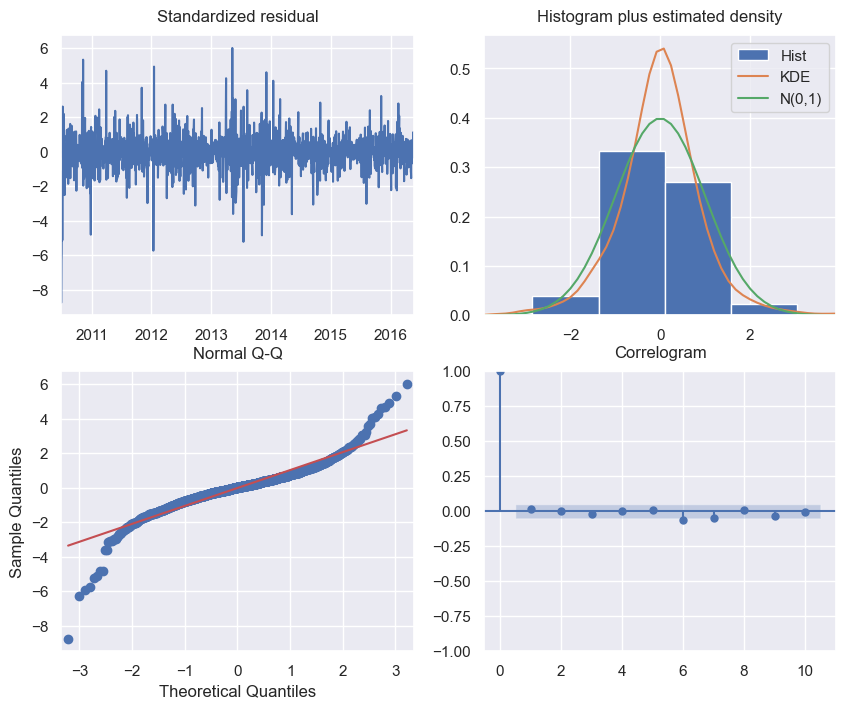

In [875]:
model_arimax_vol.plot_diagnostics(figsize=(10,8))
plt.show()

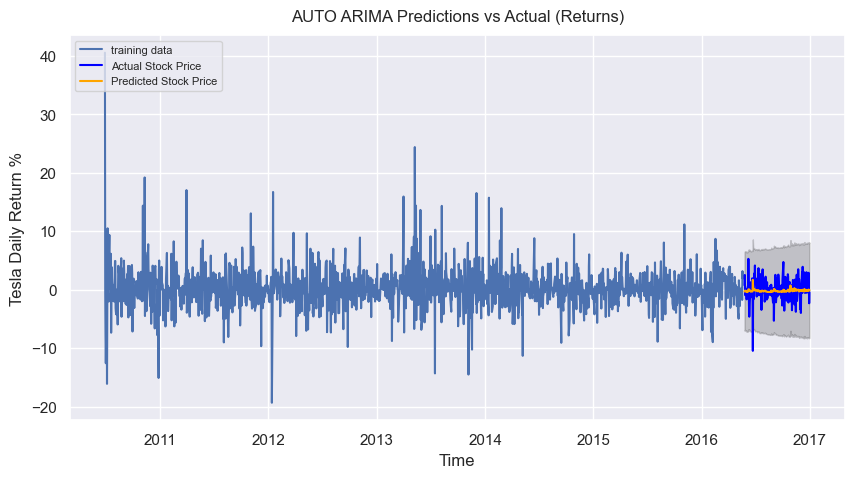

In [882]:
x = np.array(df_test.Volume[start_date:end_date])
x = x.reshape(x.size,1)

start_date = '2016-05-25'
end_date = '2017-01-01'

# Forecast
df_auto_pred, conf = model_arimax_vol.predict(n_periods=len(df_test[start_date:end_date]), X=x, return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test[start_date:end_date].index)
lower_series = pd.Series(conf[:, 0], index=df_test[start_date:end_date].index)
upper_series = pd.Series(conf[:, 1], index=df_test[start_date:end_date].index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Returns, label='training data')
plt.plot(df_test[start_date:end_date].Returns, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

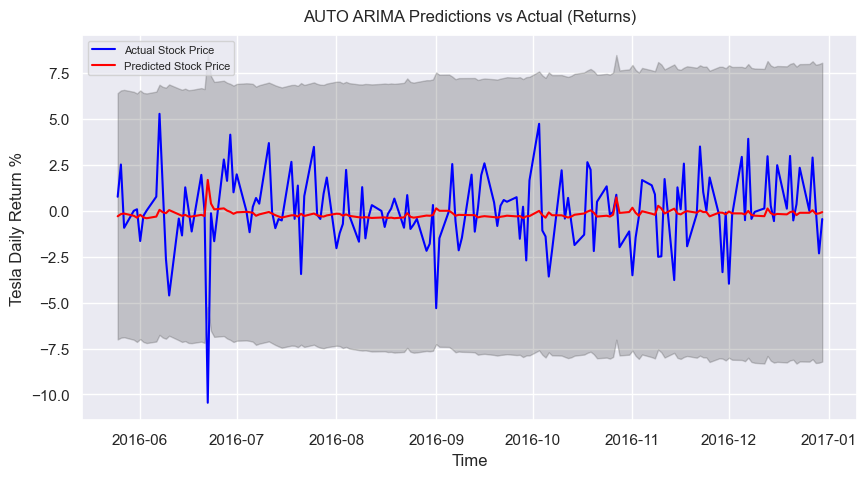

In [883]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_test[start_date:end_date].Returns, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.xlabel('Time')
plt.ylabel('Tesla Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [709]:
error = mean_squared_error(df_test[start_date:end_date].Returns, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test[start_date:end_date].Returns.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 4.337
Symmetric mean absolute percentage error: 163.409


### Machine Learning

#### Linear Regression

In [886]:
x = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=42)

In [887]:
regression = LinearRegression()
regression.fit(x_train, y_train)
print('regression coefficients: ', regression.coef_)
print('regression intercept: ', regression.intercept_)

regression coefficients:  [-5.26146162e-01  8.65657596e-01  6.58733491e-01 -4.86551339e-08]
regression intercept:  0.043267182436039775


Here we will compute the coefficient of determination denoted by R², which takes values between 0 and 1, the higher the value R² the more successful the linear regression is at explaining the variation of Y values.

In [888]:
# the coefficient of determination R²
regression_confidence = regression.score(x_test, y_test)
print('linear regression confidence: ', regression_confidence)

linear regression confidence:  0.9989054106284011


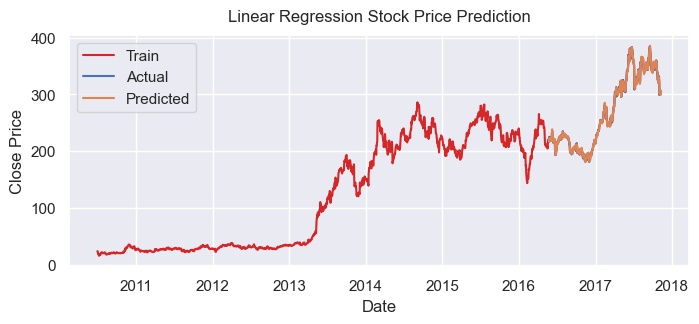

In [890]:
predicted = regression.predict(x_test)

plt.figure(figsize=(8,3))
plt.plot(df.Close,color='tab:red', label='Train')
plt.plot(y_test, label='Actual')
plt.plot(y_test.index, predicted, label='Predicted')
plt.gca().set(title='Linear Regression Stock Price Prediction', xlabel='Date', ylabel='Close Price')
plt.legend()
plt.show()

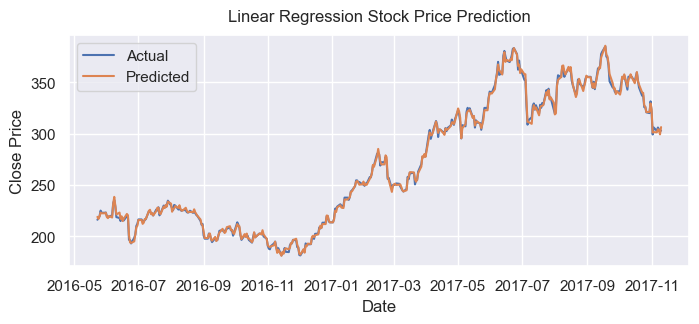

In [891]:
plt.figure(figsize=(8,3))
plt.plot(y_test, label='Actual')
plt.plot(y_test.index, predicted, label='Predicted')
plt.gca().set(title='Linear Regression Stock Price Prediction', xlabel='Date', ylabel='Close Price')
plt.legend()
plt.show()

In [897]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error (MSE) :', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error (MAE): 1.609203136776136
Mean Squared Error (MSE) : 4.225134929791963
Root Mean Squared Error (RMSE): 2.0555133008063855


#### LSTM

In [276]:
scaler = MinMaxScaler(feature_range=(0,1))
data = df.drop(['Open', 'High', 'Low', 'Volume', 'OpenInt', 'Returns'], axis=1)
final_data = data.values

len_train_data = int(len(df)*0.8)
train_data = final_data[:len_train_data, :]
valid_data = final_data[len_train_data:, :]


scaled_data = scaler.fit_transform(final_data)

x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    # take 60 previous observations as x
    x_train_data.append(scaled_data[i-60:i, 0])
    # take last observation in the 60 window as y
    y_train_data.append(scaled_data[i, 0])


In [277]:
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)

In [278]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=50, input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

2023-05-09 12:16:22.547226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [279]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=5,batch_size=1,verbose=2)

Epoch 1/5
1479/1479 - 28s - loss: 0.0019 - 28s/epoch - 19ms/step
Epoch 2/5
1479/1479 - 24s - loss: 6.8502e-04 - 24s/epoch - 16ms/step
Epoch 3/5
1479/1479 - 24s - loss: 4.8958e-04 - 24s/epoch - 16ms/step
Epoch 4/5
1479/1479 - 30s - loss: 3.7437e-04 - 30s/epoch - 20ms/step
Epoch 5/5
1479/1479 - 29s - loss: 3.4076e-04 - 29s/epoch - 19ms/step


In [280]:
model_data = data[len(data)-len(valid_data)-60:].values # 250 - 50 - 60 -> 140:250
model_data = model_data.reshape(-1,1)
model_data = scaler.transform(model_data)

In [281]:
X_test = []
for i in range(60, model_data.shape[0]):
    X_test.append(model_data[i-60:i,0]) # for the last 50 values, get their 60 previous window

X_test
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(385, 60, 1)

In [282]:
predicted_stock_price = lstm_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

13/13 [==============================] - 1s 11ms/step


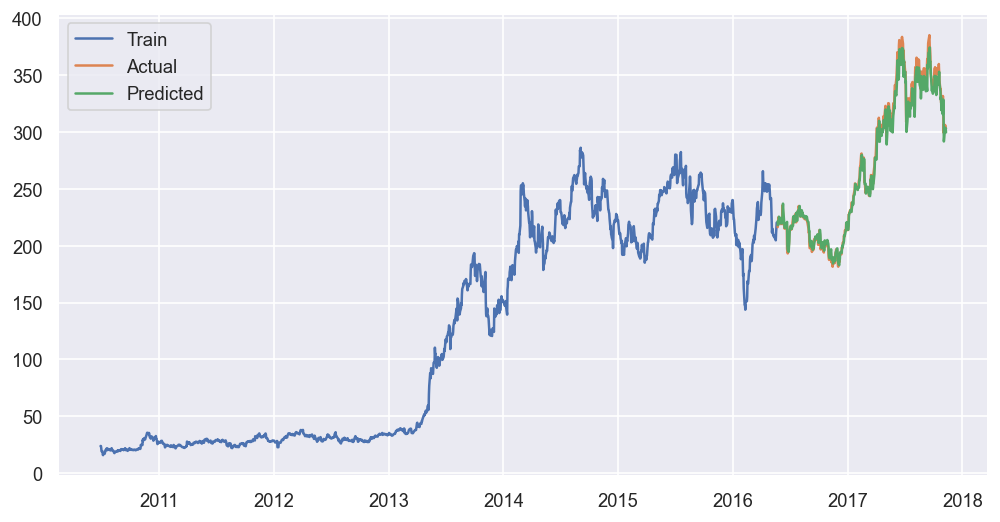

In [283]:
train_data = data[:len(train_data)]
valid_data = data[len(train_data):]
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(train_data['Close'], label='Train')
plt.plot(valid_data['Close'], label='Actual')
plt.plot(valid_data.index, predicted_stock_price, label = 'Predicted')
plt.legend()
plt.show()

## Volatility

Lower variance -> Stability -> Low risk -> Safety\
Transform data by squaring the values, penalising high differences between true values and predictions more. Increases the importance of big unpredicted shocks.

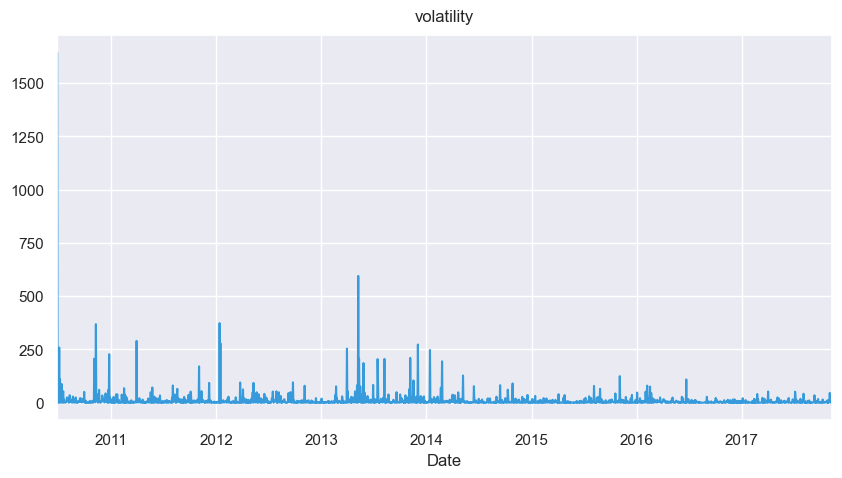

In [847]:
sq_returns = df.Returns.mul(df.Returns)
sq_returns.plot(figsize=(10,5), c='#379BDB')
plt.title('volatility')
plt.show()

High positive significant coefficients in the first few lags.\
There tend to be short-term trends in variance.\
Clustering:
- high variation -> high variation
- low variation -> low variation

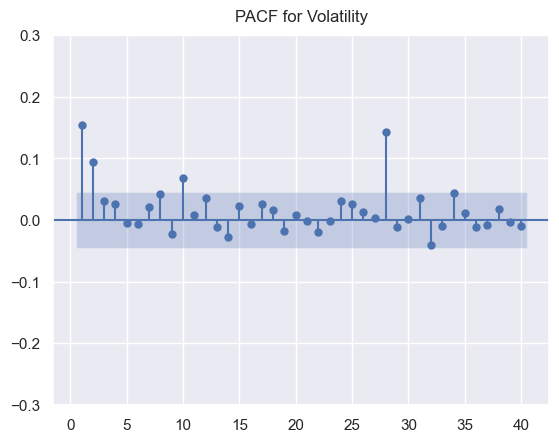

In [ ]:
sgt.plot_pacf(sq_returns, lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Volatility')
plt.ylim(-0.1,0.2)
plt.show()

In [ ]:
daily_volatility = df.Returns.std()
monthly_volatility = np.sqrt(21)*daily_volatility
annual_volatility = np.sqrt(252)*daily_volatility

from tabulate import tabulate
print(tabulate([['Tesla', daily_volatility, monthly_volatility, annual_volatility]], 
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %']))

         Daily Volatility %    Monthly Volatility %    Annual Volatility %
-----  --------------------  ----------------------  ---------------------
Tesla               3.35279                 15.3644                53.2239


### GARCH

ARCH/GARCH can only be used to predict future variance rather than future returns

GARCH(1,1) is the best model for measuring volatility of returns -> no need to rely on overly complicated models.\
All the effects of the conditional variance 2 days ago will be contained in the conditional variance of yesterday.
- Omega: constant
- Alpha: coefficients for squared residuals. The bigger it is, the stronger the immediate volatility impact is 
- Beta: coefficients for the conditional variance from the last period. The bigger it is, the longer the volatility impact is.

p: ARCH order, past squared residuals - equivalent to MA in ARMA\
q: GARCH order, past conditional variances - equivalent to AR in ARMA\
mean: 'Constant' -> serially uncorrelated mean (mean doesn't rely on past values or errors)


In [575]:
from arch.__future__ import reindexing

model_garch = arch_model(df_train.Returns, vol='GARCH', p=1,q=1,mean='constant',dist='normal')
results_garch = model_garch.fit(disp='Off')
results_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1068803536.4316576
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1546783.0810968098
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4426.037401003398
Iteration:      4,   Func. Count:     27,   Neg. LLF: 4473.014448562099
Iteration:      5,   Func. Count:     33,   Neg. LLF: 4015.8377054920325
Iteration:      6,   Func. Count:     38,   Neg. LLF: 4015.339335890779
Iteration:      7,   Func. Count:     43,   Neg. LLF: 4015.0662307524353
Iteration:      8,   Func. Count:     48,   Neg. LLF: 4014.875095363606
Iteration:      9,   Func. Count:     53,   Neg. LLF: 4014.862187878035
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4014.8545790523854
Iteration:     11,   Func. Count:     63,   Neg. LLF: 4014.8543828344955
Iteration:     12,   Func. Count:     68,   Neg. LLF: 4014.8543709242354
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4014.8543709245832


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4014.85
Distribution:                  Normal   AIC:                           8037.71
Method:            Maximum Likelihood   BIC:                           8059.06
                                        No. Observations:                 1539
Date:                Tue, May 09 2023   Df Residuals:                     1538
Time:                        19:09:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2003  8.427e-02      2.377  1.745e-02 [3.515e-02,  0.365]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          2.0704      0.747      2.770  5.602e-03    [  0.606,  3.535]
alpha[1]       0.0797  4.549e-02      1.753  7.966e-02 [-9.430e-03,  0.169]
beta[1]        0.7319  8.688e-02      8.425  3.617e-17    [  0.562,  0.902]
===========================================================================

Covariance estimator: robust
"""

Text(0.5, 1.0, 'Rolling Predictions')

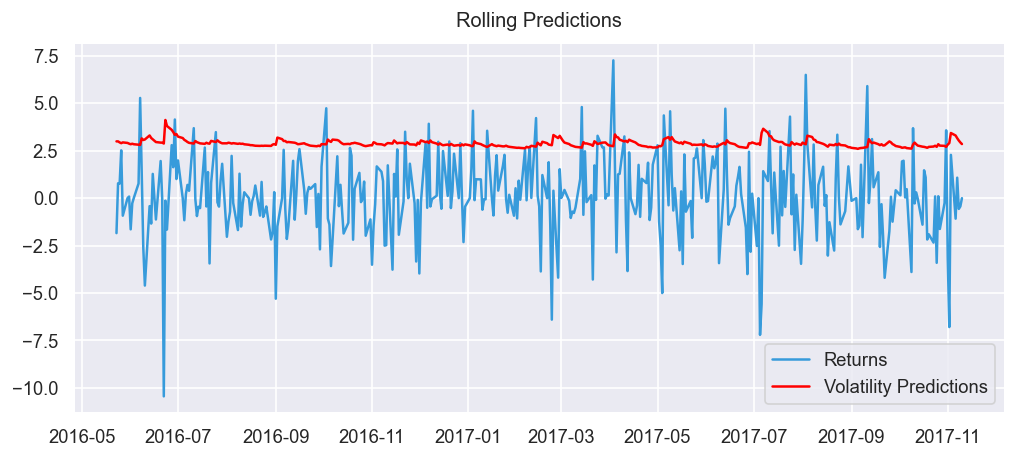

In [577]:
rolling_predictions = []
test_size = len(df_test)
for i in range(len(df_test)):
    train = df.Returns[:-(test_size-i)]
    model = arch_model(train, p=1,q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=df_test.index)
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top', 'right']].set_visible(False)
plt.plot(df_test.Returns, color='#379BDB', label='Returns')
plt.plot(rolling_predictions, color='red', label='Volatility Predictions')
plt.legend(loc='best')
plt.title('Rolling Predictions')

## Trading Strategy

### Buy and Hold

In [99]:
log_returns = np.log(df.Close).diff()
log_returns = log_returns[1:]
log_returns.head()

Date
2010-06-29    0.340247
2010-06-30   -0.002515
2010-07-01   -0.081723
2010-07-02   -0.134312
2010-07-05    0.000000
Freq: B, Name: Close, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


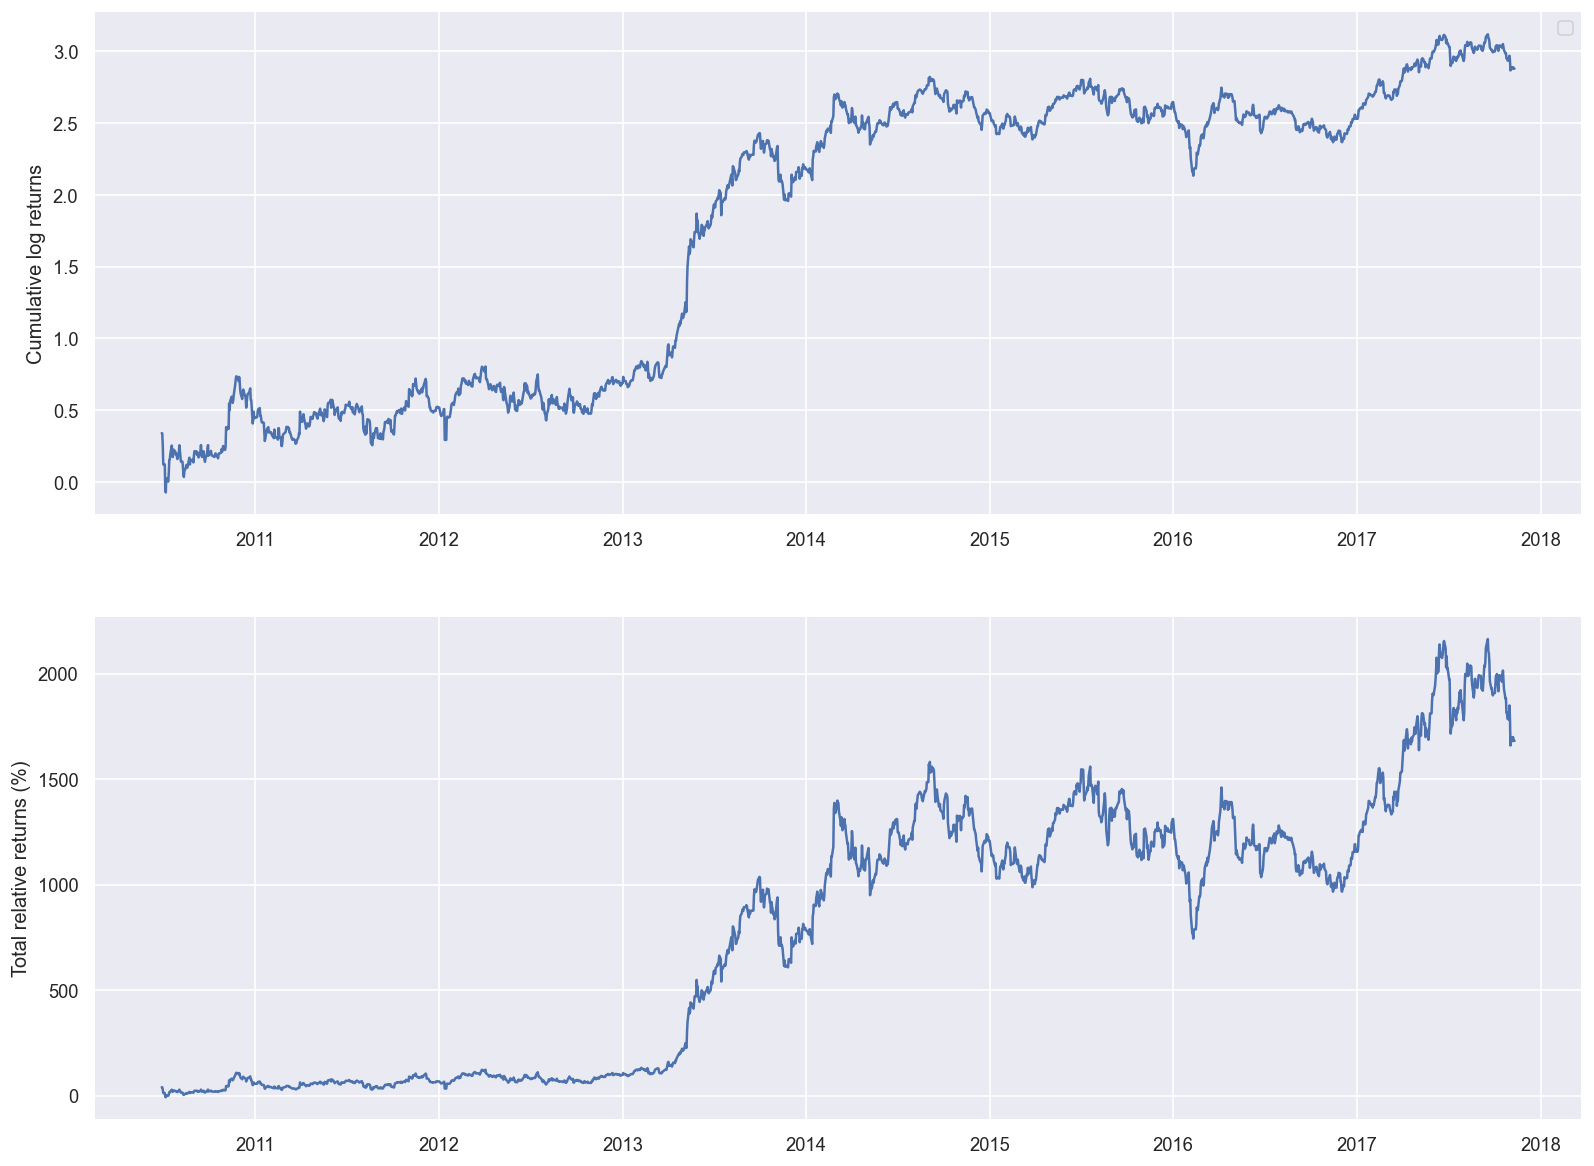

In [104]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.plot(log_returns.index, log_returns.cumsum())

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')

ax2.plot(log_returns.index, 100*(np.exp(log_returns.cumsum()) - 1))

ax2.set_ylabel('Total relative returns (%)')

plt.show()

In [107]:
df.Close[-1]-df.Close[0]

285.99

### Moving Average

In [108]:
# Calculating the short-window simple moving average
short_rolling = df.Close.rolling(window=20).mean()

# Calculating the long-window simple moving average
long_rolling = df.Close.rolling(window=100).mean()

Text(0, 0.5, 'Price in $')

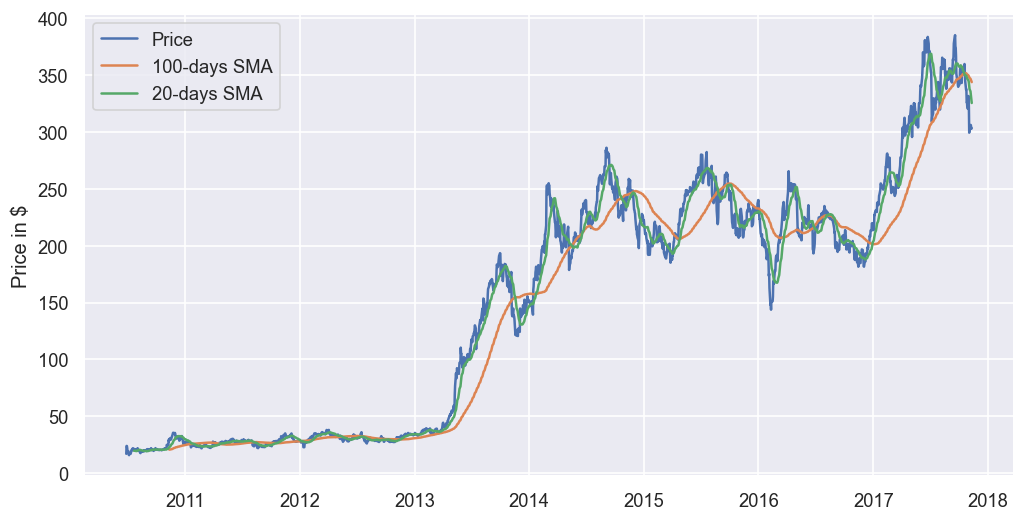

In [110]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df.Close, label='Price')
ax.plot(long_rolling, label = '100-days SMA')
ax.plot(short_rolling, label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

Text(0, 0.5, 'Price in $')

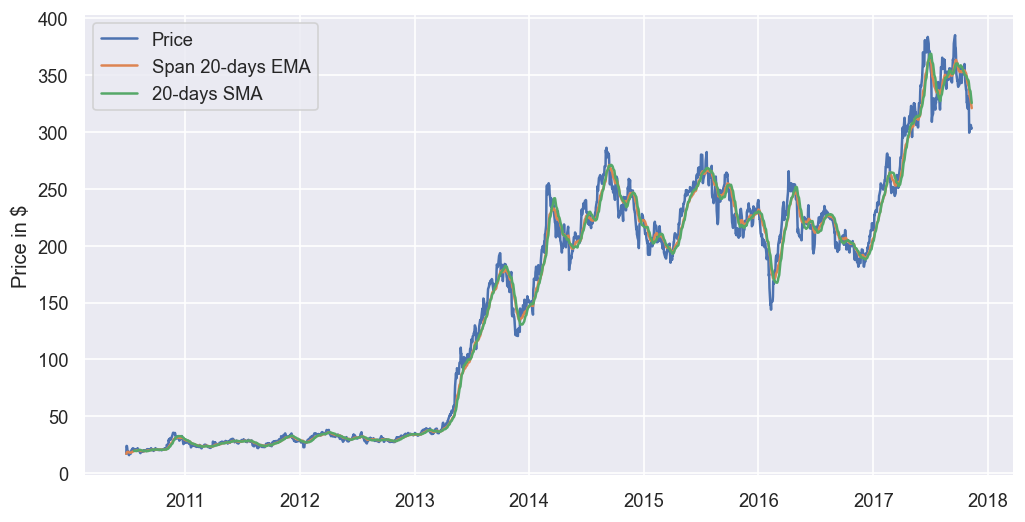

In [112]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = df.Close.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df.Close, label='Price')
ax.plot(ema_short, label = 'Span 20-days EMA')
ax.plot(short_rolling, label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

When the price timeseries crosses the EMA timeseries from below, we will close any existing short position and go long (buy) one unit of the asset.\
When the price timeseries crosses the EMA timeseries from above, we will close any existing long position and go short (sell) one unit of the asset.

In [113]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = df.Close - ema_short

# Taking the sign of the difference to determine whether the price or the EMA is greater 
trading_positions = trading_positions_raw.apply(np.sign) 

# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

Text(0, 0.5, 'Trading position')

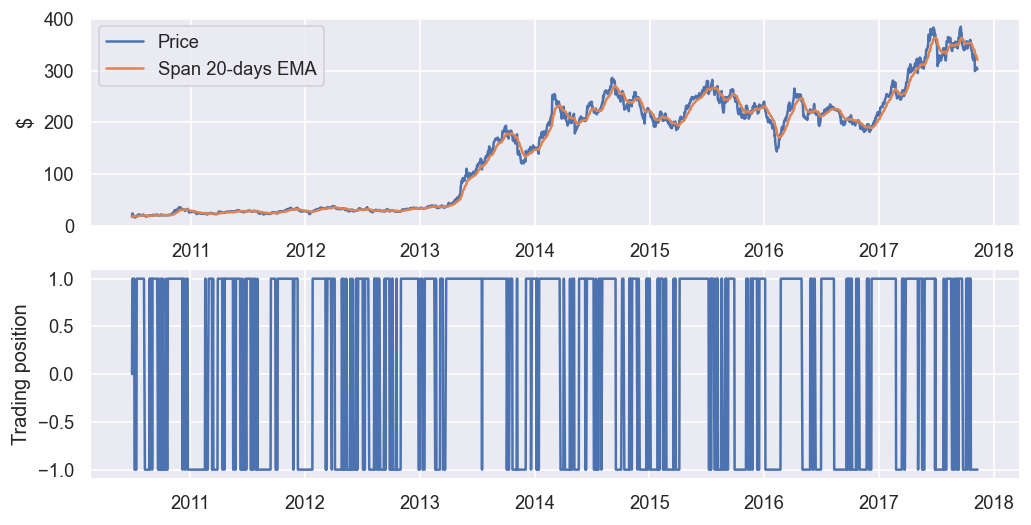

In [114]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(df.Close, label='Price')
ax1.plot(ema_short, label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')

ax2.plot(trading_positions_final, label='Trading position')
ax2.set_ylabel('Trading position')

In [115]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(df.Close).diff()
strategy_asset_log_returns = trading_positions_final * asset_log_returns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


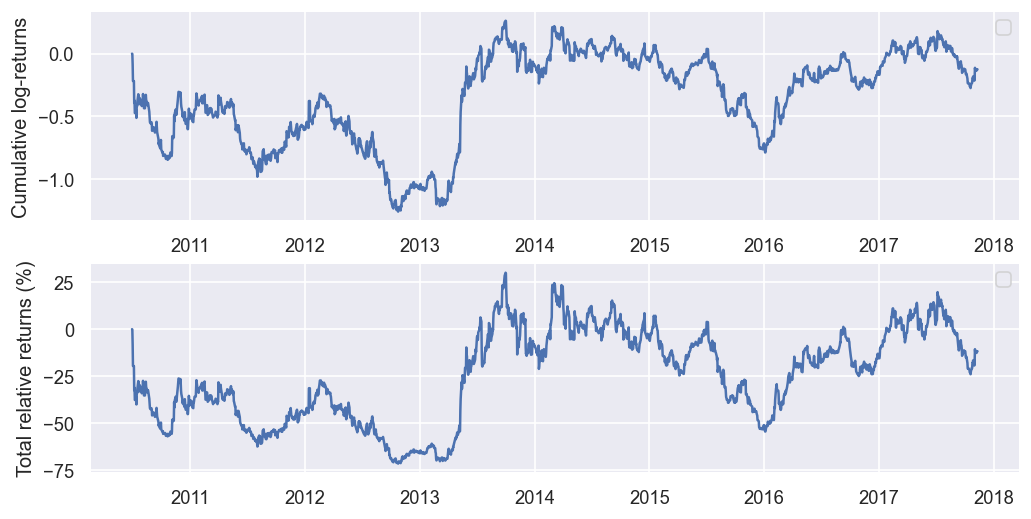

In [117]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(cum_strategy_asset_log_returns)
ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')

ax2.plot(100*cum_strategy_asset_relative_returns)
ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

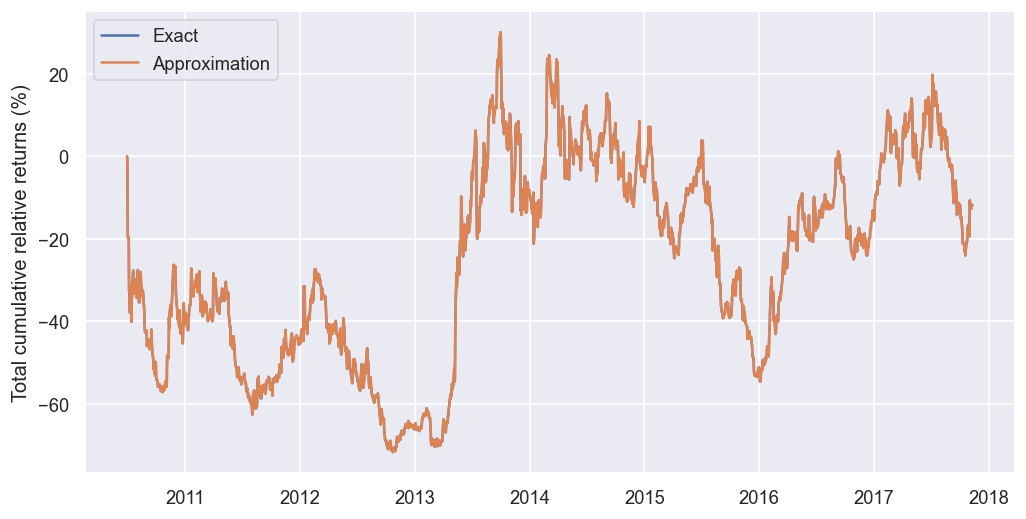

In [121]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(100*cum_relative_return_exact, label='Exact')
ax.plot(100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')

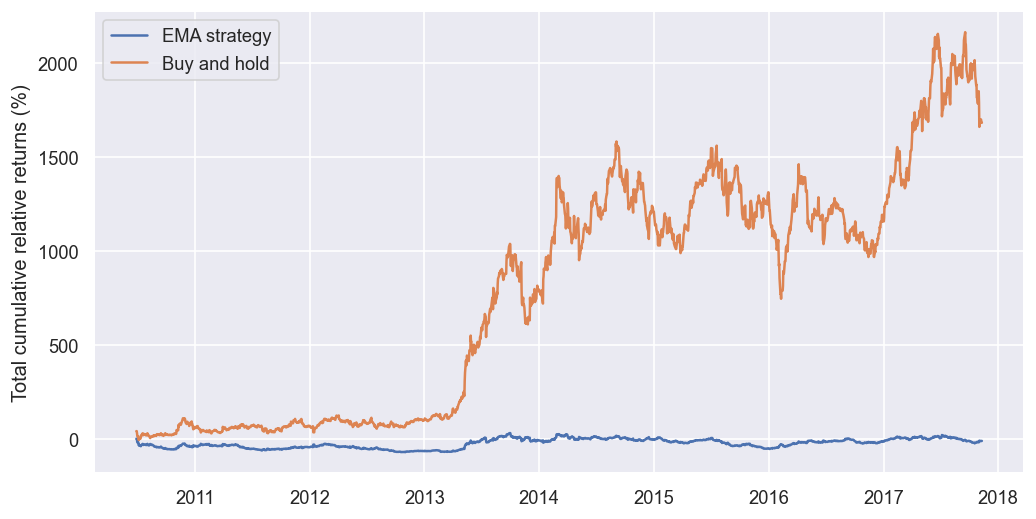

In [124]:
# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')


In [350]:
buy_n_hold = []

for cur_value in df.Close:
    buy_n_hold.append(cur_value - df.Close[0])

### Moving Average Crossover

#### Backtesting for the MA Crossover Strategy

In [351]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

# MA windows
MA = [3,7]

In [352]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [353]:
for i in range(max(MA)+1, len(df)):
    # Moving Averages
    ma1 = np.mean(df.Close[i-MA[0]:i])
    ma2 = np.mean(df.Close[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df.Close[i])

    if ma1>ma2:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Close[i]-entry)
                # record exit times
                t.append(i)
            # enter short position
            entry = df.Close[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Close[i])
                t.append(i)
            # enter long position
            entry = df.Close[i]
            inpos = 1

#### Realised P&L

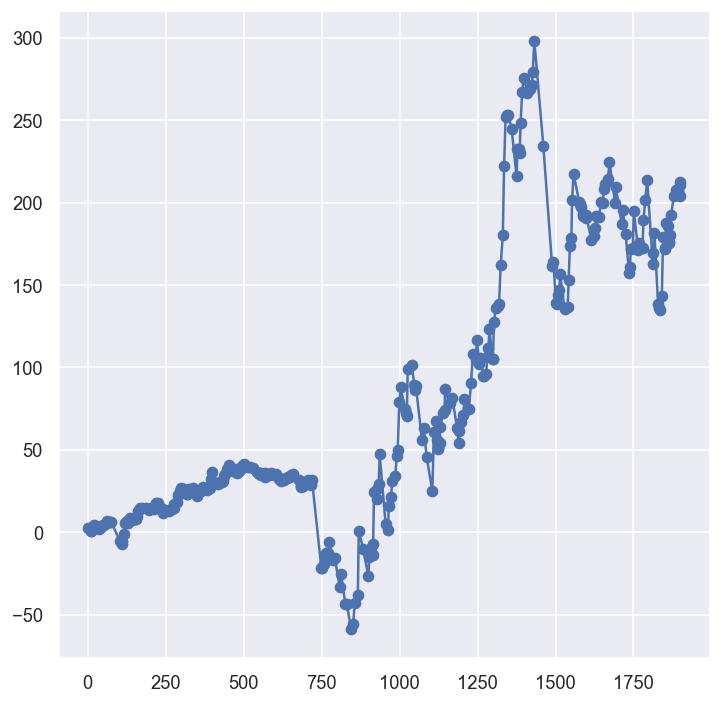

In [354]:
plt.plot(np.array(t)-max(MA)-2, np.cumsum(rlsd), '-o')

#### Unrealised P&L

In [355]:
unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

178.14600000000038 212.1760000000002


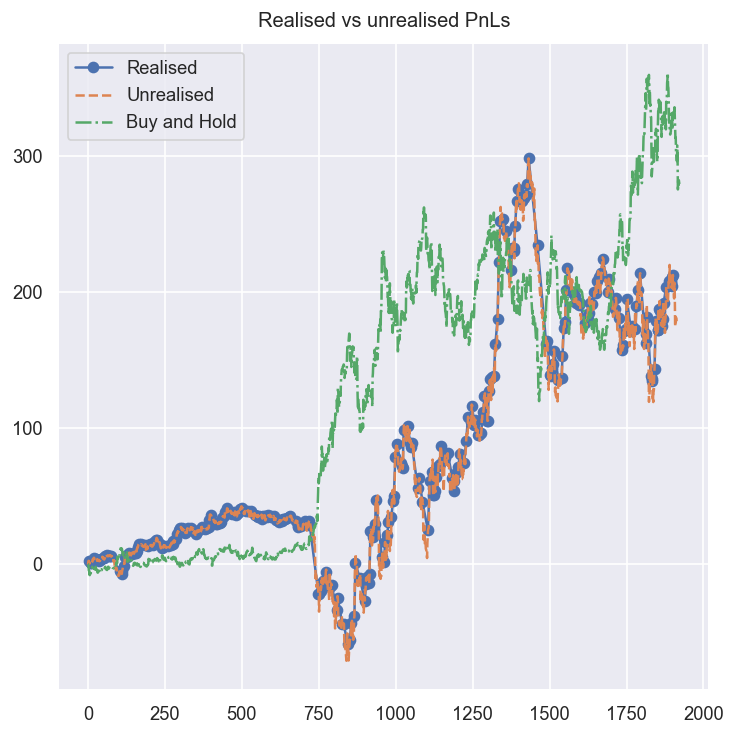

In [356]:
# Compare the realised and unrealised PnLs
plt.plot(np.array(t)-max(MA)-2, np.cumsum(rlsd), '-o')
plt.plot(unrlsd, '--')
plt.plot(buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

### Long/short

In [290]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

In [291]:
for i in range(3, len(df)):

    pos.append(inpos)
    prices.append(df.Close[i])

    if df.Returns[i-2]>0 and df.Returns[i-1]>0 and df.Returns[i]>0:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Close[i]-entry)
                # record exit times
                t.append(i)
            # enter short position
            entry = df.Close[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Close[i])
                t.append(i)
            # enter long position
            entry = df.Close[i]
            inpos = 1

In [292]:
unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

491.8499999999999 531.8


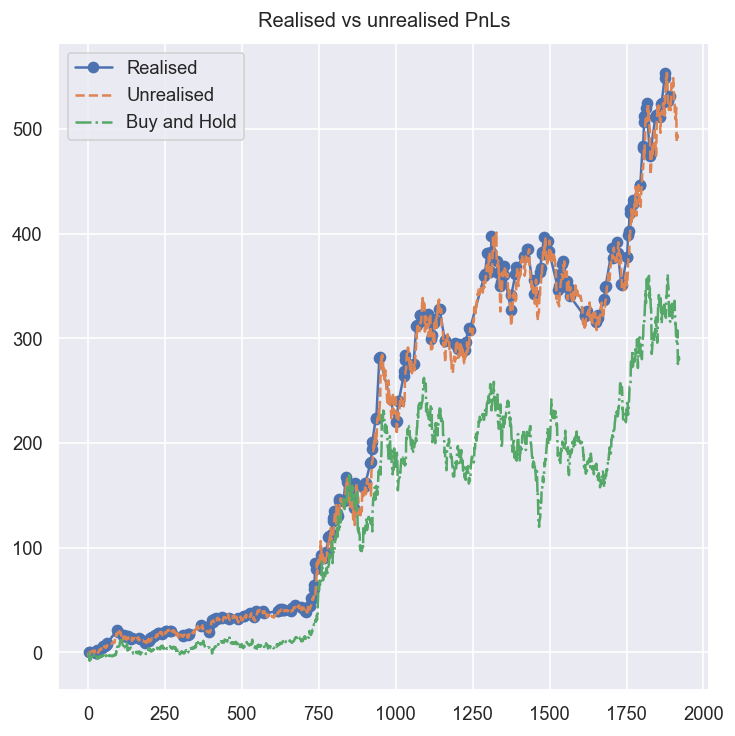

In [293]:
# Compare the realised and unrealised PnLs
plt.plot(np.array(t)-max(MA)-2, np.cumsum(rlsd), '-o')
plt.plot(unrlsd, '--')
plt.plot(buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

## Trading Strategy with Backtesting

Assume zero spreads and no commission

In [369]:
buy_n_hold_train = []

for cur_value in df_train.Close:
    buy_n_hold_train.append(cur_value - df_train.Close[0])

In [371]:
buy_n_hold_test = []

for cur_value in df_test.Close:
    buy_n_hold_test.append(cur_value - df_test.Close[0])

### Moving Average Crossover

#### Backtesting for the MA Crossover Strategy

In [562]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

# MA windows
MA = [3,7]

In [563]:
for i in range(max(MA)+1, len(df_train)):
    # Moving Averages
    ma1 = np.mean(df_train.Close[i-MA[0]:i])
    ma2 = np.mean(df_train.Close[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df_train.Close[i])

    if ma1>ma2:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df_train.Close[i]-entry)
                # record exit times
                t.append(df_train.index[i])
            # enter short position
            entry = df_train.Close[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df_train.Close[i])
                t.append(df_train.index[i])
            # enter long position
            entry = df_train.Close[i]
            inpos = 1

#### Realised P&L

#### Unrealised P&L

If final calculations do not match is because test ends in the middle of a trade and there is a residual unrealised profit for that

In [564]:
unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

135.23600000000016 135.236


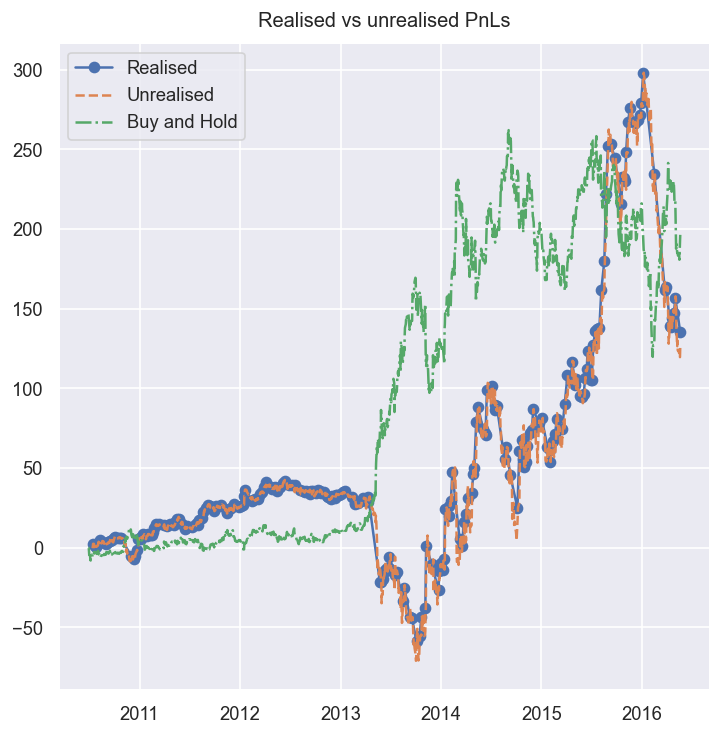

In [565]:
# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df_train.index.get_loc(t[0])
plt.plot(df_train.index[start:(start+len(unrlsd))], unrlsd[:-2], '--')
plt.plot(df_train.index, buy_n_hold_train, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

#### Backtesting

63.35000000000011 66.45000000000007


(array([16922., 16983., 17045., 17106., 17167., 17226., 17287., 17348.,
        17410., 17471.]),
 [Text(16922.0, 0, '2016-05'),
  Text(16983.0, 0, '2016-07'),
  Text(17045.0, 0, '2016-09'),
  Text(17106.0, 0, '2016-11'),
  Text(17167.0, 0, '2017-01'),
  Text(17226.0, 0, '2017-03'),
  Text(17287.0, 0, '2017-05'),
  Text(17348.0, 0, '2017-07'),
  Text(17410.0, 0, '2017-09'),
  Text(17471.0, 0, '2017-11')])

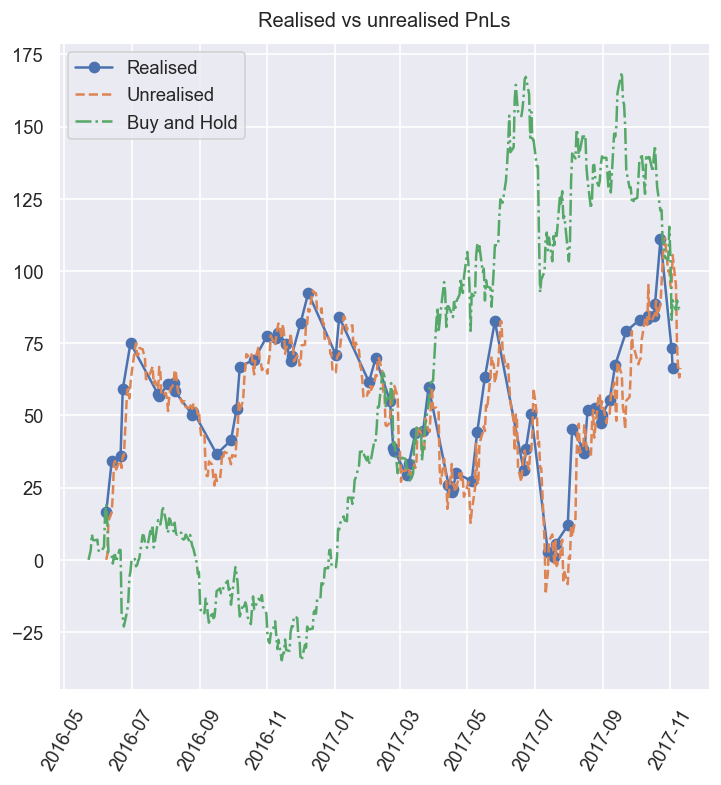

In [570]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd_test = []

# Exit times
t_test = []

# MA windows
MA = [2,7]

for i in range(max(MA)+1, len(df_test)):
    # Moving Averages
    ma1 = np.mean(df_test.Close[i-MA[0]:i])
    ma2 = np.mean(df_test.Close[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df_test.Close[i])

    if ma1>ma2:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd_test.append(df_test.Close[i]-entry)
                # record exit times
                t_test.append(df_test.index[i])
            # enter short position
            entry = df_test.Close[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd_test.append(entry-df_test.Close[i])
                t_test.append(df_test.index[i])
            # enter long position
            entry = df_test.Close[i]
            inpos = 1

unrlsd_test = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd_test = unrlsd_test[-1]
print(final_unrlsd_test, sum(rlsd_test))

# Compare the realised and unrealised PnLs
plt.plot(t_test, np.cumsum(rlsd_test), '-o')
start = df_test.index.get_loc(t_test[0])
plt.plot(df_test.index[start:(start+len(unrlsd_test))],unrlsd_test[:-3], '--')
plt.plot(df_test.index, buy_n_hold_test, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])
plt.xticks(rotation=60)

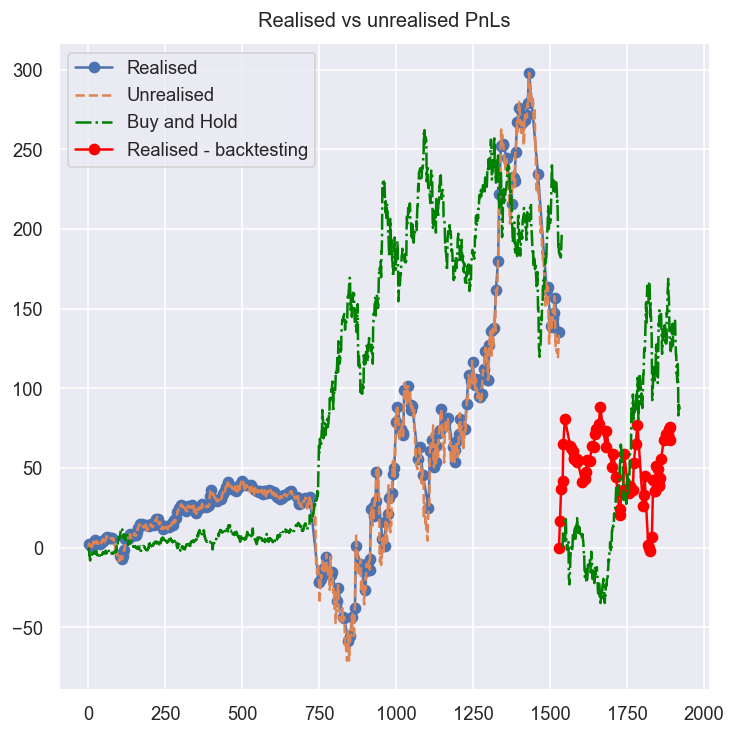

In [406]:
# Compare the realised and unrealised PnLs
plt.plot(np.array(t)-max(MA)-2, np.cumsum(rlsd), '-o')
plt.plot(unrlsd, '--')
plt.plot(buy_n_hold_train, '-.', c='green')
plt.plot(1529+np.array(t_test)-max(MA)-2, np.cumsum(rlsd_test), '-o', c='black')
plt.plot(np.arange(len(buy_n_hold_train),len(buy_n_hold_train)+len(buy_n_hold_test)), buy_n_hold_test, '-.', c='green')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold', 'Realised - backtesting'])

### Mean reversion

In [443]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

In [444]:
for i in range(3, len(df_train)):

    pos.append(inpos)
    prices.append(df_train.Close[i])

    if df_train.Returns[i-2]>0 and df_train.Returns[i-1]>0 and df_train.Returns[i]>0:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df_train.Close[i]-entry)
                # record exit times
                t.append(df_train.index[i])
            # enter short position
            entry = df_train.Close[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df_train.Close[i])
                t.append(df_train.index[i])
            # enter long position
            entry = df_train.Close[i]
            inpos = 1

In [445]:
unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

346.0799999999996 346.0799999999999


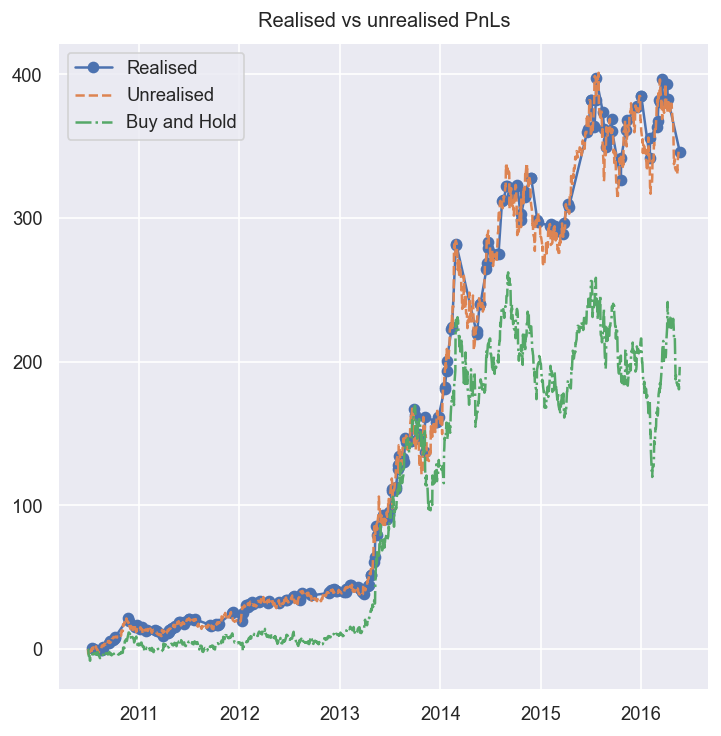

In [452]:
# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
plt.plot(df_train.index[:len(unrlsd)],unrlsd, '--')
plt.plot(df_train.index, buy_n_hold_train, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

132.80999999999995 172.75999999999993


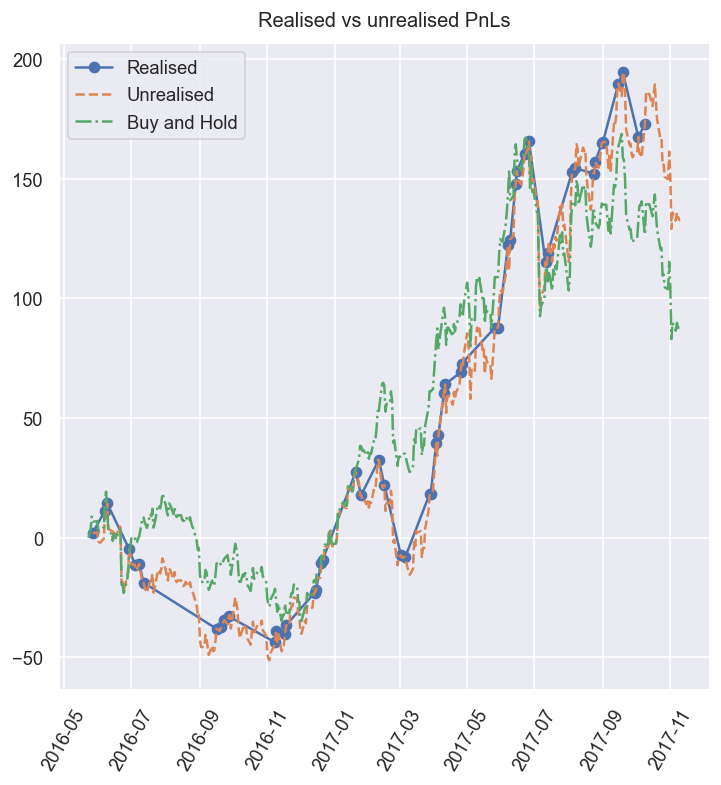

In [584]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0
# Positions
pos = []
# Prices
prices = []
# Realised PnL
rlsd_test= []
# Exit times
t_test = []

for i in range(3, len(df_test)):

    pos.append(inpos)
    prices.append(df_test.Close[i])

    if df_test.Returns[i-2]>0 and df_test.Returns[i-1]>0 and df_test.Returns[i]>0:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd_test.append(df_test.Close[i]-entry)
                # record exit times
                t_test.append(df_test.index[i])
            # enter short position
            entry = df_test.Close[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd_test.append(entry-df_test.Close[i])
                t_test.append(df_test.index[i])
            # enter long position
            entry = df_test.Close[i]
            inpos = 1

unrlsd_test = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd_test = unrlsd_test[-1]
print(final_unrlsd_test, sum(rlsd_test))

# Compare the realised and unrealised PnLs
plt.plot(t_test, np.cumsum(rlsd_test), '-o')
start = df_test.index.get_loc(t_test[0])
plt.plot(df_test.index[start:start+len(unrlsd_test)],unrlsd_test, '--')
plt.plot(df_test.index, buy_n_hold_test, '-.')
plt.title('Realised vs unrealised PnLs')
plt.xticks(rotation=60)
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

#### Profit factor

In our strategies, we want to have a profit factor of at least 1.75 depending on the type of strategy we’re dealing with. In breakout strategies, 1,5 might be on the lower end, but still fully acceptable, if the other metrics of the strategy look okay.

However, in mean reversion strategies we demand a higher profit factor of at least 2, depending on the circumstances.

In [588]:
rlsd_test_pos = [x for x in rlsd_test if x>0]
rlsd_test_neg = [x for x in rlsd_test if x<0]

profit_factor = -sum(rlsd_test_pos)/sum(rlsd_test_neg)
profit_factor

1.8874049722621733